In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
!pip freeze > requirements.txt

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb kaggle pytorch-nlp 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install wandb --quiet
!pip install python-Levenshtein -q
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget -q
%cd ctcdecode
!pip install . -q
%cd ..

!pip install torchsummaryX -q
!pip install pytorch-nlp

Cloning into 'ctcdecode'...
remote: Enumerating objects: 1102, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 1102 (delta 16), reused 32 (delta 14), pack-reused 1063
Receiving objects: 100% (1102/1102), 782.27 KiB | 5.79 MiB/s, done.
Resolving deltas: 100% (529/529), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 14147, done.        
remote: Counting objects: 100% (460/460), done.        
remote: Compressing objects: 100% (319/319), done.        
remote: Total 14147 (delta 152

# Imports

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import torchaudio.transforms as tat

from sklearn.metrics import accuracy_score
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime

import ctcdecode
import Levenshtein
from ctcdecode import CTCBeamDecoder
from torchnlp.nn import LockedDropout

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


# Toy Dataset Download

In [ ]:
!wget -q https://cmu.box.com/shared/static/om4qpzd4tf1xo4h7230k4v1pbdyueghe --content-disposition --show-progress
!unzip -q hw4p2_toy.zip -d ./

hw4p2_toy.zip       100%[===================>] 343.92M  12.1MB/s    in 29s     


# Kaggle Dataset Download

In [ ]:
api_token = '{"username":<username>,"key":<key>}'


!mkdir /root/.kaggle/

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write(api_token)

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# To download the dataset
!kaggle datasets download -d varunjain3/11-785-s23-hw4p2-dataset

100% 3.74G/3.74G [03:02<00:00, 25.0MB/s]
100% 3.74G/3.74G [03:02<00:00, 22.0MB/s]


In [ ]:
# To unzip data quickly and quietly
!unzip -q 11-785-s23-hw4p2-dataset.zip -d ./data

In [ ]:
chars = np.load('/content/data/train-clean-100/transcripts/103-1240-0000.npy')
print(chars)

['<sos>' 'C' 'H' 'A' 'P' 'T' 'E' 'R' ' ' 'O' 'N' 'E' ' ' 'M' 'I' 'S' 'S'
 'U' 'S' ' ' 'R' 'A' 'C' 'H' 'E' 'L' ' ' 'L' 'Y' 'N' 'D' 'E' ' ' 'I' 'S'
 ' ' 'S' 'U' 'R' 'P' 'R' 'I' 'S' 'E' 'D' ' ' 'M' 'I' 'S' 'S' 'U' 'S' ' '
 'R' 'A' 'C' 'H' 'E' 'L' ' ' 'L' 'Y' 'N' 'D' 'E' ' ' 'L' 'I' 'V' 'E' 'D'
 ' ' 'J' 'U' 'S' 'T' ' ' 'W' 'H' 'E' 'R' 'E' ' ' 'T' 'H' 'E' ' ' 'A' 'V'
 'O' 'N' 'L' 'E' 'A' ' ' 'M' 'A' 'I' 'N' ' ' 'R' 'O' 'A' 'D' ' ' 'D' 'I'
 'P' 'P' 'E' 'D' ' ' 'D' 'O' 'W' 'N' ' ' 'I' 'N' 'T' 'O' ' ' 'A' ' ' 'L'
 'I' 'T' 'T' 'L' 'E' ' ' 'H' 'O' 'L' 'L' 'O' 'W' ' ' 'F' 'R' 'I' 'N' 'G'
 'E' 'D' ' ' 'W' 'I' 'T' 'H' ' ' 'A' 'L' 'D' 'E' 'R' 'S' ' ' 'A' 'N' 'D'
 ' ' 'L' 'A' 'D' 'I' 'E' 'S' ' ' 'E' 'A' 'R' 'D' 'R' 'O' 'P' 'S' ' ' 'A'
 'N' 'D' ' ' 'T' 'R' 'A' 'V' 'E' 'R' 'S' 'E' 'D' ' ' 'B' 'Y' ' ' 'A' ' '
 'B' 'R' 'O' 'O' 'K' '<eos>']


In [ ]:
config = {
  'batch_size': 128
}

VOCAB = ['<pad>', '<sos>', '<eos>', 
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         ]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab: {len(VOCAB)}")
print(f"Vocab: {VOCAB}")
print(f"PAD_TOKEN: {PAD_TOKEN}")
print(f"SOS_TOKEN: {SOS_TOKEN}")
print(f"EOS_TOKEN: {EOS_TOKEN}")

Length of vocab: 31
Vocab: ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN: 0
SOS_TOKEN: 1
EOS_TOKEN: 2


In [ ]:
print(VOCAB_MAP)

{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'Q': 19, 'R': 20, 'S': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28, "'": 29, ' ': 30}


In [ ]:
import torch

class SpeechDataset(torch.utils.data.Dataset):
    '''
    Feel free to add arguments, additional functions, this is the 
    bare-minimum template.
    '''
    def __init__(self, root = '/content/data', partition = 'train-clean-100', context = 0, offset = 0):

        self.mfcc_dir = root + '/' +  partition + '/mfcc'
        self.transcript_dir = root + '/' + partition + '/transcripts'  

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        self.VOCAB_MAP = VOCAB_MAP


        self.mfccs, self.transcripts = [], []

        for i in range(len(self.mfcc_files)):

            mfcc        = np.load(self.mfcc_dir + '/' + self.mfcc_files[i])  
            mfcc = (mfcc -  np.mean(mfcc, axis = 0)) / np.std(mfcc, axis = 0)

            transcript  = np.load(self.transcript_dir + '/' + self.transcript_files[i])
            
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)        

        
        self.length = len(self.mfccs)

        t = []
        for tr in self.transcripts:
          t.append(np.array([self.VOCAB_MAP[i] for i in tr]))
        self.transcripts = t


        

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        mfcc = self.mfccs[ind] # TODO
        transcript = self.transcripts[ind] # TODO
        mfcc = torch.tensor(mfcc)
        transcript = torch.tensor(transcript)
        return mfcc, transcript

    def collate_fn(self,batch):
        # update to numpy--->tensor
        batch_mfcc = [batch_item[0] for batch_item in batch] # TODO

        batch_transcript = [batch_item[1] for batch_item in batch] # TODO

        
        batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, padding_value = PAD_TOKEN, batch_first=True) # TODO
        lengths_mfcc = [len(item) for item in batch_mfcc] # TODO 

        batch_transcript_pad = torch.nn.utils.rnn.pad_sequence(batch_transcript, padding_value = PAD_TOKEN, batch_first=True) # TODO
        lengths_transcript = [len(item) for item in batch_transcript] # TODO

        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [ ]:
class SpeechDatasetTest(torch.utils.data.Dataset):
    
    def __init__(self, root = '/content/data', partition = "test-clean"): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        self.mfcc_dir = root + '/' + partition + '/mfcc'
        
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        self.VOCAB_MAP = VOCAB_MAP

       
        self.length = len(self.mfcc_files) 
        

        self.mfccs = []

        for i in range(len(self.mfcc_files)):

            mfcc = np.load(self.mfcc_dir + '/' + self.mfcc_files[i])
            mfcc = (mfcc -  np.mean(mfcc, axis = 0)) / np.std(mfcc, axis = 0)
        
            self.mfccs.append(mfcc)

       
        self.length = len(self.mfccs)

       

    def __len__(self):
        
        return self.length

    def __getitem__(self, ind):
        
        mfcc = self.mfccs[ind]
        mfcc = torch.FloatTensor(mfcc)
        return mfcc


    def collate_fn(self,batch):
        # batch of input mfcc coefficients
        batch_mfcc = batch

        batch_mfcc_pad = torch.nn.utils.rnn.pad_sequence(batch_mfcc, padding_value = PAD_TOKEN, batch_first=True) # TODO
        lengths_mfcc = [len(item) for item in batch_mfcc]

        return batch_mfcc_pad, torch.tensor(lengths_mfcc)


In [ ]:
train_dataset = SpeechDataset(partition = 'train-clean-100')
dev_dataset = SpeechDataset(partition='dev-clean')
test_dataset = SpeechDatasetTest()


train_loader = DataLoader(train_dataset, shuffle = True, collate_fn = train_dataset.collate_fn, batch_size = config['batch_size'])
dev_loader = DataLoader(dev_dataset, shuffle = True, collate_fn = dev_dataset.collate_fn, batch_size = config['batch_size'])
test_loader = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size = config['batch_size'])


In [ ]:
print("\nChecking the shapes of the data...")
for batch in dev_loader:
    x, y, x_len, y_len = batch
    print(x.shape, y.shape, x_len.shape, y_len.shape)
    break


Checking the shapes of the data...
torch.Size([128, 2282, 27]) torch.Size([128, 374]) torch.Size([128]) torch.Size([128])


# THE MODEL 

### Listen, Attend and Spell
Listen, Attend and Spell (LAS) is a neural network model used for speech recognition and synthesis tasks.

- LAS is designed to handle long input sequences and is robust to noisy speech signals.
- LAS is known for its high accuracy and ability to improve over time with additional training data.
- It consists of an <b>listener, an attender and a speller</b>, which work together to convert an input speech signal into a corresponding output text.

#### The Dataflow:
<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/DataFlow.png" alt="data flow" height="100">
</center>

#### The Listener: 
- converts the input speech signal into a sequence of hidden states.

#### The Attender:
- Decides how the sequence of Encoder hidden state is propogated to decoder.

#### The Speller:
- A language model, that incorporates the "context of attender"(output of attender) to predict sequence of words.






In [ ]:
class MetaConfig():
    def __init__(self, vocab_size, listener_input_size, listener_hidden_size, attention_head_size, n_embed, 
                 speller_hidden_size, max_timesteps, teacher_forcing_ratio, locked_dropout_rate, epochs, lr):
        self.vocab_size = vocab_size
        self.listener_input_size = listener_input_size
        self.listener_hidden_size = listener_hidden_size
        self.attention_head_size = attention_head_size

        self.encoder_output_size = listener_hidden_size * 8
        self.decoder_output_size = speller_hidden_size


        self.n_embed = n_embed
        self.speller_hidden_size = speller_hidden_size

        self.max_timesteps = max_timesteps
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.locked_dropout_rate = locked_dropout_rate

        self.epochs = epochs
        self.lr = lr


    def wandb_config(self):
        d = dict()
        d['epochs'] = self.epochs
        d['lr'] = self.lr
        d['teacher_forcing_ratio'] = self.teacher_forcing_ratio

        return d





In [ ]:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 

# Attention Projection Size of 128

meta_config = MetaConfig(
    vocab_size = len(VOCAB), 

    listener_input_size = 27, 
    listener_hidden_size = 128, 

    attention_head_size = 128, 

    n_embed = 256, 
    speller_hidden_size = 512, 

    max_timesteps = 550, 
    teacher_forcing_ratio = 0.9, 
    locked_dropout_rate = 0.2, 

    epochs = 98, 
    lr = 1e-4
)

## The Listener:

In [ ]:
class pBLSTM(torch.nn.Module):
    
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(batch_first = True, input_size = input_size * 2, hidden_size = hidden_size, 
                          num_layers = 3, bidirectional=True)

    def forward(self, x_packed): # x_packed is a PackedSequence

        x_pack_padded, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        
        x_downsample, x_lens = self.trunc_reshape(x_pack_padded, x_lens)

        x = pack_padded_sequence(x_downsample, x_lens, batch_first=True, enforce_sorted=False)

        output, hidden = self.blstm(x)

        # What do you return?
        return output, hidden

    def trunc_reshape(self, x, x_lens): 
        batch_size, max_len, feat_dim = x.size()
        if max_len % 2 == 0:
            ds = max_len // 2
            x = x.view(batch_size, ds, feat_dim * 2)
        else:
            x = x[:, :-1, :]
            ds = (max_len - 1) // 2
            x = x.view(batch_size, (max_len - 1) // 2, feat_dim * 2)
        x_lens = torch.clamp(x_lens, max = ds)
        return x, x_lens

In [ ]:
class Listener(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size):
        super().__init__()
        self.feature_embed = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels = input_size, out_channels = encoder_hidden_size, kernel_size = 3, stride = 1, padding = 1), 
            torch.nn.BatchNorm1d(encoder_hidden_size), 
            torch.nn.ReLU(), 

            torch.nn.Conv1d(in_channels = encoder_hidden_size, out_channels = encoder_hidden_size * 2, kernel_size = 3, stride = 1, padding = 1), 
            torch.nn.BatchNorm1d(encoder_hidden_size * 2), 
            torch.nn.ReLU(), 

            torch.nn.Conv1d(in_channels = encoder_hidden_size * 2, out_channels = encoder_hidden_size * 2, kernel_size = 3, stride = 1, padding = 1), 
            torch.nn.BatchNorm1d(encoder_hidden_size * 2), 
            torch.nn.ReLU()
        )

        self.pblstm_0 = pBLSTM(input_size = encoder_hidden_size * 2, hidden_size = encoder_hidden_size * 2)

        self.pBLSTMs = torch.nn.Sequential(
            *[
                pBLSTM(
                        input_size = encoder_hidden_size * 2 * (2 ** i),
                        hidden_size = encoder_hidden_size * 2 * (2 ** i)
                    )
                    for i in range(1, 2)
            ]
        )

        self.locked_dropout = LockedDropout(meta_config.locked_dropout_rate)

  
    def forward(self, x, lx):
        x = x.transpose(1, 2)
        x = self.feature_embed(x)
        x = x.transpose(1, 2)
        x = pack_padded_sequence(x, lx, batch_first = True, enforce_sorted = False)
        x, _ = self.pblstm_0.forward(x)
        
        for layer in self.pBLSTMs:
            x, _ = layer.forward(x)
            x, encoder_lens = pad_packed_sequence(x, batch_first = True)
            
            b, t, hs = x.shape
            x = x.view(t, b, hs)
            x = self.locked_dropout(x)
            
            t, b, hs = x.shape
            x = x.view(b, t, hs)
            encoder_outputs = x

        return encoder_outputs, encoder_lens

## Attention

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.head_size = meta_config.attention_head_size

        self.key = torch.nn.Linear(meta_config.encoder_output_size, self.head_size, bias = False)
        self.query = torch.nn.Linear(meta_config.decoder_output_size, self.head_size, bias = False)
        self.value = torch.nn.Linear(meta_config.encoder_output_size, self.head_size, bias = False)


    def set_key_value(self, encoder_outputs):
        self.k = self.key(encoder_outputs)
        self.v = self.value(encoder_outputs)

    def compute_context(self, decoder_context):
        #print("ATTENTION: ", decoder_context.shape)
        # decoder_context ----> (B, 1, encoder_output_shape)
        # k ----> (B, T, head_size)
        # v ----> (B, T, head_size)
        # q ----> (B, 1, head_size)

        b, es = decoder_context.shape
        decoder_context = decoder_context.view(b, 1, es)

        q = self.query(decoder_context)

        # updated
        #wei = (q / torch.sqrt(torch.norm(q, dim = -1, keepdim = True))) @ self.k.transpose(-2, -1)
        # torch.bmm or einsum
        wei = torch.matmul((q / torch.sqrt(torch.norm(q, dim = -1, keepdim = True))), self.k.transpose(-2, -1))

        wei = F.softmax(wei, dim = -1)

        # wei ----> (B, 1, T)

        # torch.bmm or einsum
        context = torch.matmul(wei, self.v)

        # context ----> (B, 1, head_size)
        return context, wei

## The Speller

Similar to the language model that you coded up for HW4P1, you have to code a language model for HW4P2 as well. This time, we will also call the attention context step, within the decoder to get the attended-encoder-embeddings.


What you have coded till now:

<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/EncoderAttention.png" alt="data flow" height="400">
</center>

For the Speller, what we have to code:


<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/Decoder.png" alt="data flow" height="400">
</center>

In [ ]:
class Speller(torch.nn.Module):

  def __init__(self, vocab_size, n_embed, hidden_size, attender:Attention, max_timesteps):
    super(). __init__()

    self.attend = attender
    self.max_timesteps = max_timesteps
    self.vocab_size = vocab_size
    self.n_embed = n_embed
    self.hidden_size = hidden_size

    # Embedding Layer
    self.embedding =  torch.nn.Embedding(self.vocab_size, self.n_embed)

    # Create a sequence of LSTM Cells
    self.lstm_cells =  torch.nn.Sequential(
        torch.nn.LSTMCell(input_size = self.n_embed + self.attend.head_size, hidden_size=self.hidden_size),
        torch.nn.LSTMCell(input_size = self.hidden_size, hidden_size=self.hidden_size), 
        torch.nn.LSTMCell(input_size = self.hidden_size, hidden_size=self.hidden_size)
    ) 

   
    self.output_to_char = torch.nn.Linear(self.hidden_size + self.attend.head_size, self.n_embed)
    
    self.activation = torch.nn.ReLU()


    self.char_prob = torch.nn.Linear(self.n_embed, self.vocab_size)
    
    # Weight tying (From embedding layer)
    self.char_prob.weight = self.embedding.weight


  def lstm_step(self, input_word, hidden_state):
    for i in range(len(self.lstm_cells)):
        hidden_state[i] = self.lstm_cells[i].forward(input_word, hidden_state[i])
        input_word = hidden_state[i][0]
    return input_word, hidden_state
    
  def CDN(self, x):
    x = self.output_to_char(x)
    #x = self.activation(x)
    x = self.char_prob(x)
    return x
    
  def forward (self, batch_size, y=None, teacher_forcing_ratio=None):
    
    # (B, 1, head_size)
    attn_context =  torch.randn(size = (batch_size, self.attend.head_size)).to(device) # initial context tensor for time t = 0
    output_symbol = torch.broadcast_to(torch.tensor(SOS_TOKEN), (batch_size, )).to(device) # Set it to SOS for time t = 0
    raw_outputs = []  
    attention_plot = []
      
    if y is None:
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0

    else:
      timesteps = y.shape[-1]

    hidden_states_list = [None]*len(self.lstm_cells)

    for t in range(timesteps):
      # generate a probability p between 0 and 1
      p = torch.rand(1).item()

      if p < teacher_forcing_ratio and t > 0:
        output_symbol = y[:, t-1] # Take from y, else draw from probability distribution

      # (B, n_embed)
      char_embed = self.embedding(output_symbol) # Embed the character symbol

      # char_embed ----> (B, n_embed)
      # attn_context ----> (B, head_size)
      # (B, n_embed + head_size)
      lstm_input = torch.cat((char_embed, attn_context), dim = -1)

      # Feed the input through LSTM Cells and attention.
      lstm_out, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list)

    
      attn_context, attn_weights = self.attend.compute_context(lstm_out)


      # lstm_out ----> (B, hidden_size)
      # attn_context ----> (B, head_size)

      #b, hs = lstm_out.shape
      # lstm_out = lstm_out.view(b, 1, hs)
      attn_context = attn_context.squeeze()
      cdn_input = torch.cat((lstm_out, attn_context), dim = -1)


      # (B, vocab_size)
      raw_pred = self.CDN(cdn_input) # call CDN with cdn_input

      output_symbol = torch.argmax(raw_pred, dim = -1) # Draw correctly from raw_pred

      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights.squeeze()) # for plotting attention plot

    
    attention_plot = torch.stack(attention_plot, dim=1)
    raw_outputs = torch.stack(raw_outputs, dim=1)


    return raw_outputs, attention_plot

## LAS

Here we finally build the LAS model, comibining the listener, attender and speller together, we have given a template, but you are free to read the paper and implement it yourself.

In [ ]:
print(y.shape)

torch.Size([128, 374])


In [ ]:
class LAS(torch.nn.Module):
  def __init__(self, vocab_size, n_embed, max_timesteps, teacher_forcing_ratio, 
               input_size, listener_hidden_size, speller_hidden_size): # add parameters
    super().__init__()

    # Pass the right parameters here
    self.listener = Listener(input_size = input_size, encoder_hidden_size=listener_hidden_size)
    self.attend = Attention()
    self.speller = Speller(vocab_size = vocab_size, n_embed = n_embed, hidden_size = speller_hidden_size, 
                           attender = self.attend, max_timesteps = max_timesteps)
    


    self.augmentations  = torch.nn.Sequential(
            tat.TimeMasking(20),
            tat.FrequencyMasking(20)
        )

  def forward(self, x, lx, teacher_forcing_ratio, y = None):

    if self.training:
        x = self.augmentations(x)

    
    # Encode speech features
    encoder_outputs, _ = self.listener.forward(x,lx)

    self.attend.set_key_value(encoder_outputs)

    raw_outputs, attention_plots = self.speller.forward(teacher_forcing_ratio=teacher_forcing_ratio, batch_size = x.shape[0], y = y)

    return raw_outputs, attention_plots

# Model Setup 

In [ ]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Attention Projection Size of 128
# Feel Free to Experiment with this 

model = LAS(
    vocab_size = meta_config.vocab_size, 
    n_embed = meta_config.n_embed, 
    max_timesteps = meta_config.max_timesteps, 
    teacher_forcing_ratio = meta_config.teacher_forcing_ratio, 
    input_size = meta_config.listener_input_size, 
    listener_hidden_size = meta_config.listener_hidden_size, 
    speller_hidden_size = meta_config.speller_hidden_size

)

model = model.to(device)
print(model)
print(x.shape, y.shape)
summary(model, x.to(device), x_len, y.to(device))

LAS(
  (listener): Listener(
    (feature_embed): Sequential(
      (0): Conv1d(27, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (pblstm_0): pBLSTM(
      (blstm): LSTM(512, 256, num_layers=3, batch_first=True, bidirectional=True)
    )
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 512, num_layers=3, batch_first=True, bidirectional=True)
      )
    )
    (locked_dropout): LockedDropout(p=0.2)
  )
  (attend): Attention(
    (key): Linear(in_features=1024, out_features=128, bia

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_augmentations.TimeMasking_0,-,"[128, 2282, 27]",NaN,NaN
1_augmentations.FrequencyMasking_1,-,"[128, 2282, 27]",NaN,NaN
2_listener.feature_embed.Conv1d_0,"[27, 128, 3]","[128, 128, 2282]",10496.0,23659776.0
3_listener.feature_embed.BatchNorm1d_1,[128],"[128, 128, 2282]",256.0,128.0
4_listener.feature_embed.ReLU_2,-,"[128, 128, 2282]",NaN,NaN
...,...,...,...,...
2763_speller.Embedding_embedding,"[256, 31]","[128, 256]",NaN,7936.0
2764_speller.attend.Linear_query,"[512, 128]","[128, 1, 128]",NaN,65536.0
2765_speller.attend.Linear_query,"[512, 128]","[128, 1, 128]",NaN,65536.0


In [ ]:
ckpt = torch.load('/content/drive/MyDrive/IDL/best_model-schedule-final-run-1.pth')
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [ ]:
'''print(VOCAB_MAP_TOY)'''

'print(VOCAB_MAP_TOY)'

# Loss Function, Optimizers, Scheduler

In [ ]:
class TFSchedule():
    def __init__(self):
        pass

    # exp decay 0.9. to *0.99
    def reduce_tf(self, epoch):
        if epoch < 15:
            return 0.9
        if epoch < 32:
            return 0.895
        if epoch < 42:
            return 0.89
        if epoch < 60:
            return 0.88
        if epoch < 77:
            return 0.87
        if epoch < 89:
            return 0.86
        if epoch < 95:
            return 0.85

In [ ]:
optimizer   = torch.optim.Adam(model.parameters(), lr= meta_config.lr, weight_decay=0.01) # Feel free to experiment if needed
optimizer.load_state_dict(ckpt['optimizer_state_dict'])
criterion   = torch.nn.CrossEntropyLoss(reduction = 'mean', ignore_index=PAD_TOKEN, label_smoothing=0.1) #check how would you fill these values : https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
scaler      = torch.cuda.amp.GradScaler()
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=4) #TODO
scheduler.load_state_dict(ckpt['scheduler_state_dict'])
tf_scheduler = TFSchedule()

In [ ]:
print(ckpt['optimizer_state_dict'])

{'state': {0: {'step': tensor(4796.), 'exp_avg': tensor([[[ 1.7513e-04, -1.1048e-04, -1.0971e-04],
         [ 3.3239e-04,  1.9244e-04,  8.5001e-05],
         [-9.0328e-04, -9.5225e-04, -9.1769e-04],
         ...,
         [-4.9714e-04, -2.5828e-04, -2.1792e-04],
         [-4.3644e-04, -2.6024e-04, -1.4959e-04],
         [-4.4692e-04, -3.0689e-04, -1.5867e-04]],

        [[-3.0583e-04, -3.0047e-04, -3.1915e-04],
         [ 1.0336e-04,  2.3127e-04,  2.3458e-04],
         [-2.6579e-04, -2.2189e-04, -2.5743e-04],
         ...,
         [ 2.6073e-04,  2.1205e-04,  1.9551e-04],
         [-8.4060e-05, -2.0239e-04, -2.2008e-04],
         [-1.0489e-06, -6.1524e-05, -1.1395e-04]],

        [[ 6.4265e-05, -1.4805e-04, -2.3604e-04],
         [-4.3360e-04, -4.2676e-04, -3.6209e-04],
         [-4.5976e-05, -6.0244e-05, -1.2374e-04],
         ...,
         [-8.4817e-04, -1.8313e-04,  7.8522e-05],
         [-2.0222e-04, -2.3325e-04, -2.4556e-04],
         [-2.0170e-04, -3.5424e-04, -3.7640e-04]],

   

# Levenshtein Distance

In [ ]:
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[int(i)])
    return tokens

def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx, 0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above and uncomment below for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Validation functions 


In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(device), y.to(device), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y= y, teacher_forcing_ratio= teacher_forcing_rate)

            B, T, vocab_size = raw_predictions.shape
            raw_predictions = raw_predictions.view(B * T, vocab_size)
            y = y.view(B*T)


            loss        =  criterion(raw_predictions, y)

            perplexity  = torch.exp(loss)
            running_loss        += loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(loss).backward()
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):
        '''if x.shape[0] != config['batch_size']:
            continue'''

        x, y, lx, ly = x.to(device), y.to(device), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None, teacher_forcing_ratio = 0)

        # Greedy Decoding
        # raw_predictions ----> (B, T, vocab_size)
        # y ----> (B, T)
        greedy_predictions   = torch.argmax(raw_predictions, dim = -1) 

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = True) 
        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

# Experiment

In [ ]:
# Login to Wandb
import wandb
wandb.login(key="<key>")
# Save your model architecture in a txt file, and save the file to Wandb

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(
    name = "LAS-model-tf-run", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    #run_id = "cl6ttn54", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw4p2-krana", ### Project should be created in your wandb account 
    config = meta_config.wandb_config() ### Wandb Config for your run
)

wandb: Currently logged in as: krana (cmu-idl). Use `wandb login --relogin` to force relogin


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         metric[0]                  : metric[1], 
         'epoch'                    : epoch}, 
         path
    )

def load_model(path, model, metric= 'valid_acc', optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

In [ ]:
# get me RAMMM!!!! 

torch.cuda.empty_cache()

In [ ]:
epoch_model_path = 'chekpoint-schedule-run.pth'
best_model_path = 'best_model-schedule-run.pth'


Epoch: 18/98


Val:   5%|▍         | 1/22 [00:02<01:02,  2.98s/it, dist=21.8594]

Ground Truth :  WHAT WILL THE MORAL PHILOSOPHERS WHO APPEAR AT THIS TIME HAVE TO PREACH
Prediction   :  WHAT WILL THE MORAL THE LOSS OF FERS WHO WAPPEARED THIS TIME HAVE TO PREACH


Val:   9%|▉         | 2/22 [00:06<01:00,  3.04s/it, dist=24.4180]

Ground Truth :  SAID MORREL SADLY YES REPLIED NOIRTIER
Prediction   :  SAID MEREL SADLY YES REPLIED MORE TAY


Val:  14%|█▎        | 3/22 [00:09<00:57,  3.04s/it, dist=23.7474]

Ground Truth :  AND ALL WORK HAD CEASED WITH HIM
Prediction   :  AND ALWARE HAD CEASED WITH HIM


Val:  18%|█▊        | 4/22 [00:12<00:55,  3.06s/it, dist=24.2773]

Ground Truth :  PHOEBE COOKED VENUS SCRUBBED THE TEMPLE
Prediction   :  FEEBY CUT BE MISS GROUND ATTEMPLE


Val:  23%|██▎       | 5/22 [00:15<00:51,  3.06s/it, dist=24.0797]

Ground Truth :  IT'S THE MOST INEXPLICABLE THERE
Prediction   :  IT'S THE MOST IN EXPLUCABLE THEY ARE


Val:  27%|██▋       | 6/22 [00:18<00:49,  3.07s/it, dist=23.4622]

Ground Truth :  I WON'T HAVE MY MEN KNOCKED UP WITH FLOGGING THESE RASCALS
Prediction   :  I WON'T HAVE MY MEN NOT DUT WITH FLOG IN THESE RASCALS


Val:  32%|███▏      | 7/22 [00:21<00:44,  2.97s/it, dist=22.9163]

Ground Truth :  OF COURSE IT AIN'T SAID MISSUS BOZZLE
Prediction   :  OF COURSE IT AND SAID MISSUS BASSEL


Val:  36%|███▋      | 8/22 [00:23<00:40,  2.90s/it, dist=23.2207]

Ground Truth :  AS FOR HIS FRIENDS THE FUTURE MUST PROVE HIS GRATITUDE TO THEM
Prediction   :  AS FREE HIS FRIENDS THE FEATY REMOST BROVE HIS GRATITUDE TO THEM


Val:  41%|████      | 9/22 [00:27<00:38,  2.98s/it, dist=23.6345]

Ground Truth :  HE TROUBLED OVER MANY LITTLE DETAILS AND TALKED PERFUNCTORILY TO EVERYBODY
Prediction   :  HE GENELED OVER MANY LITTLE DETAILS AND TAKS PERFECT TO ALL TO EVERYBODY


Val:  45%|████▌     | 10/22 [00:29<00:34,  2.89s/it, dist=23.3727]

Ground Truth :  WHEN QUITE CRISP DIP ONE SIDE OF THE SIPPET INTO THE BEATEN WHITE OF AN EGG MIXED WITH A LITTLE FLOUR AND PLACE IT ON THE EDGE OF THE DISH
Prediction   :  WHEN QUITE CRIST DID ONE SIDE OF THE SIP IT INTO THE BEATING WHITE OF AN AGMIX WITH A LITTLE FLOWER AND PLACE IT ON THE EDGE OF THE DISH


Val:  50%|█████     | 11/22 [00:32<00:30,  2.80s/it, dist=22.9808]

Ground Truth :  WHAT BANKRUPTS IN THE WORLD WE FEEL WHEN DEATH LIKE SOME REMORSELESS CREDITOR SEIZES ON ALL WE FONDLY THOUGHT OUR OWN THE TWINS
Prediction   :  WHAT ANGRAPS IN THE WORLD REFEEL WENDEATH LIKE SOME REMORE STISCREDED HER SEASES ON ALL WE FUNDLY SAT OUR OWN THE TWINS


Val:  55%|█████▍    | 12/22 [00:34<00:27,  2.76s/it, dist=23.1270]

Ground Truth :  DAVID AND CHRISTIE WENT SMILING AWAY TOGETHER AND IF THEY SHED ANY TEARS OVER THE BRIEF HAPPINESS NO ONE SAW THEM BUT THE FLOWERS AND THEY LOYALLY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS
Prediction   :  EVER INCRESS YOU WENT SMILING AWAY TOGETHER AND DIFFERE SHAD AN YETER IS IF OR THE BREE FACTINESS NO ONE SAW THEM BUT THE FLOWERS AND THEY LORELY KEPT THE SECRET FOLD IN UP IN THEIR TENDER HEARTS


Val:  59%|█████▉    | 13/22 [00:37<00:24,  2.77s/it, dist=23.5721]

Ground Truth :  I DO NOT KNOW WHEN IT IS GOING TO BE BUT IT WILL BE EITHER NEXT WEEK OR THE WEEK AFTER CERTAINLY AT THE EARLIEST POSSIBLE MOMENT AND I SHOULDN'T BE AT ALL SURPRISED TO LEARN THAT ALL MARY ANN'S THINGS HAD BEEN ALREADY BOUGHT AND PERHAPS SOME OF THEM MARKED
Prediction   :  I DO NOT KNOW WHEN IT IS GOING TO BE BUT IT WILL BE EITHER NEXT WEEK OR THE WEEK DAFTER CERTAINLY AT THE EARLY SPOSSIBLE MOMENT AND I SHOULD BE A ALL SURPRISE TO LEAN THAT ALL MERE AND THINGS HAVE BEEN ALREADY BOUGHT AND PERHAPS SOME OF THE MARKED


Val:  64%|██████▎   | 14/22 [00:40<00:21,  2.69s/it, dist=23.0837]

Ground Truth :  SHALL WE HAUL UP ASKED LIGE MAKING A MEGAPHONE OF HIS HANDS YES HAUL AWAY
Prediction   :  SHE WE HALL UP ASK LYE SHE MAKING HIM ANY OF UN OF HIS HANDS YES HOLD AWAY


Val:  68%|██████▊   | 15/22 [00:43<00:19,  2.72s/it, dist=22.9854]

Ground Truth :  LINCOLN HAD CALLED FOR VOLUNTEERS TO PUT DOWN A REBELLION BUT HARRY HEARD EVERYWHERE IN CHARLESTON THAT THE CONFEDERACY WAS NOW SECURE
Prediction   :  LEACON HAD CALLED HER VALUE TEARS TO PUT DOWN A REBELLION BUT HERE HERE EVERY WERE AND CHARLES THAN THAT THE CONFEDERACY WAS NOW SECURE


Val:  73%|███████▎  | 16/22 [00:46<00:16,  2.83s/it, dist=22.9937]

Ground Truth :  HE PAUSED AND PUT HIS HAND TO HIS FEVERED HEAD
Prediction   :  HE POLISTE AND PUT HIS HAND IT WAS FEEVER HEAD


Val:  77%|███████▋  | 17/22 [00:49<00:14,  2.91s/it, dist=23.3594]

Ground Truth :  A SHOCK OF UNBELIEVABLE RELIEF TINGLED THROUGH HER SO THAT WAS ALL WHAT WAS IT COMPARED WITH HER FEARS
Prediction   :  A SHARCA THAN THE LEAVE A BILLY LEAVE SEEMILE BURTER SWITH THAT WAS ALL BUT WAS IT CONVERED THE HER FEARS


Val:  82%|████████▏ | 18/22 [00:52<00:11,  2.87s/it, dist=23.4089]

Ground Truth :  THEY LAY IN HEAPS OF DOZENS EVEN CLOSE UP TO THE WORKS
Prediction   :  THEY LAY IN HEAPS OF DOZEN EVEN CLOSE UP TO THE WORSE


Val:  86%|████████▋ | 19/22 [00:54<00:08,  2.82s/it, dist=23.1859]

Ground Truth :  WE TOOK OUR WAY THROUGH POOR AND SPARSE MEADOWS WHICH MADE A DESPERATE EFFORT EVERY YEAR TO SHOW A LITTLE GREEN
Prediction   :  WE TOOK ARE WAY THEIR POOR AND SPARSE MEADOWS WHICH MADE A DESPER EFFORT EVERY YEAR TO SHOW LITTLE GREEN


Val:  91%|█████████ | 20/22 [00:57<00:05,  2.90s/it, dist=23.2184]

Ground Truth :  THEY SAT DOWN AND LISTENED IN SILENCE
Prediction   :  THEY SAID DOWN AND LISTENED IN SILENCE


Val:  95%|█████████▌| 21/22 [01:00<00:02,  2.92s/it, dist=23.2894]

Ground Truth :  SLEEP WHICH KEEPS ALL SORROW IN ABEYANCE SOON WEIGHED DOWN THEIR EYELIDS THEY SLEPT IN EACH OTHER'S ARMS OVERCOME BY EXHAUSTION AND PROLONGED WATCHING
Prediction   :  SLEEP WHICH KEEPS ALL SORROW IN A BANCE SOON WAIT DOWN THEIR EYE LIVES THEY SLEPT ANY COLOURS ARE OVER COME BY CLARSHING AND PROWERMED WATCHING


Ground Truth :  NO HE AIN'T IT'S A TRAINER ADDED ANN LIZY
Prediction   :  NOW REA IT SUCH HANG HER ADDED AND MORE YE
Train loss: 1.007744129730447 Train Perplexity: 2.765669666598196 lr:  0.0001
Validation dist:  23.203551136363636


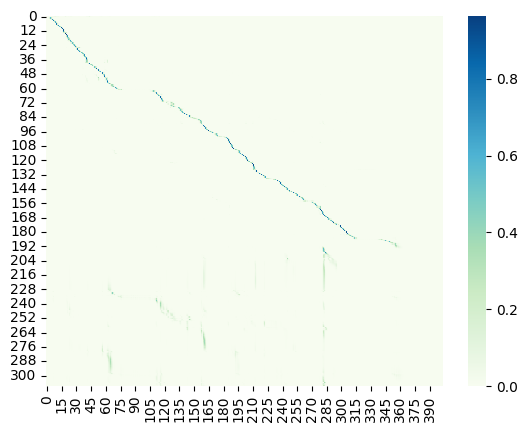

Saved epoch model
Saved best model

Epoch: 19/98


Val:   5%|▍         | 1/22 [00:02<00:59,  2.85s/it, dist=19.6562]

Ground Truth :  THAT POOR BOY IS IN A VERY EXCITED STATE TO NIGHT SHE MURMURED AFTER A PAUSE WHICH LASTED FOR THREE TICKS OF THE CLOCK
Prediction   :  THAT POOR BOYS AND VERY SAID IS TAY TO THAT SHE MURMURED AFTER A PAUSE WAS LESS FOR THREE TICKS OF THE CLOCK


Val:   9%|▉         | 2/22 [00:05<01:00,  3.02s/it, dist=21.9453]

Ground Truth :  THERE WAS AN EXTRAORDINARY FORCE OF SUGGESTION IN THIS POSTURING
Prediction   :  THERE WAS NEXT DOOR NOR A FORCE ITS UGJESTING THIS POSTURING


Val:  14%|█▎        | 3/22 [00:08<00:56,  2.96s/it, dist=20.6823]

Ground Truth :  NOR COULD IT SEEM STRANGE OR INCREDIBLE THAT THE FIRST OF THESE AEONS THE LOGOS OR WORD OF GOD OF THE SAME SUBSTANCE WITH THE FATHER SHOULD DESCEND UPON EARTH TO DELIVER THE HUMAN RACE FROM VICE AND ERROR AND TO CONDUCT THEM IN THE PATHS OF LIFE AND IMMORTALITY
Prediction   :  NOR COULD IT SEEMS STRANGERING CRITIBLE OF THE FIRST OF THESE EARNS THE LIBEST OR WORD OF GOD OF THE SAME SUBSENCE WITH THE FATHER SHE DISCEND UPON EARTH TO LIVE OF THE HUMAN RACE FROM VICE AND ERROR AND TO CONDUCT THEM IN THE PATS OF LIFE AND IMMERTALITY


Val:  18%|█▊        | 4/22 [00:11<00:51,  2.89s/it, dist=20.4336]

Ground Truth :  D'AVRIGNY SAID VILLEFORT BE SO KIND I BESEECH YOU AS TO ACCOMPANY THIS GENTLEMAN HERE IS THE KEY OF THE DOOR SO THAT YOU CAN GO IN AND OUT AS YOU PLEASE YOU WILL BRING THE PRIEST WITH YOU AND WILL OBLIGE ME BY INTRODUCING HIM INTO MY CHILD'S ROOM DO YOU WISH TO SEE HIM
Prediction   :  DEVERING HE SAID MILEFORT BE SO KIND OF AS HE TOO AS TO COME IN THIS GENEMAN HERE IS THE KING OF THE DOOR SO LET YOU CAN GOING AN OUT AS YOU PREESE YOU A GRING THE PRIEST WITH YOU AND WILL OBLIGE ME BAN AND DOORS IN HIM INTO MY CHANCE ROOM DO YOU IS TO SEE HIM


Val:  23%|██▎       | 5/22 [00:14<00:48,  2.83s/it, dist=20.0000]

Ground Truth :  THERE ARE NATURES TOO TO WHOSE SENSE OF JUSTICE THE PRICE EXACTED LOOMS UP MONSTROUSLY ENORMOUS ODIOUS OPPRESSIVE WORRYING HUMILIATING EXTORTIONATE INTOLERABLE THOSE ARE THE FANATICS
Prediction   :  THERE WERE NATURES TOO TO HER SENSE OF JUSTICE THE PRESENT EXACTED LOOSE UP MOSSIES THE ENARMISS OHIOUS AMPRESSIVE WARIING HE MILLIATING EXTORTIONATE INTORABLE THERE WAS OTHER FINATICS


Val:  27%|██▋       | 6/22 [00:17<00:46,  2.93s/it, dist=20.9779]

Ground Truth :  I UNDERSTAND BARTLEY I WAS WRONG
Prediction   :  I UNDERSTAND BARTLY I WAS RONG


Val:  32%|███▏      | 7/22 [00:20<00:44,  2.94s/it, dist=20.7790]

Ground Truth :  IS THERE NOTHING WILD IN THE EYE CONTINUED HOLGRAVE SO EARNESTLY THAT IT EMBARRASSED PHOEBE AS DID ALSO THE QUIET FREEDOM WITH WHICH HE PRESUMED ON THEIR SO RECENT ACQUAINTANCE
Prediction   :  IT THEIR NOTHING WILD IN THE EYE CONTINUED HOLDRER SO EARNESTLY THAT IMBERS FEEBY AS DID ALSO THE QUIET FREEDOM WITH WHICH HE PRESUMED ON THEIR SO REASON TO QUIET ANDS


Val:  36%|███▋      | 8/22 [00:23<00:41,  3.00s/it, dist=20.8389]

Ground Truth :  IN FACT THE RINGLEADER JOHN REX GAVE ME HIS CONFESSION AND I SENT IT TO THE BISHOP
Prediction   :  AND FACT THE RING LEADER JOHN RECKS GAVE ME HIS CONVESSION I SAID IT TO THE BISHIP


Val:  41%|████      | 9/22 [00:26<00:38,  2.97s/it, dist=21.0946]

Ground Truth :  I FELT THAT IN MY FIRST PROFESSION AS I WAS NOT BLESSED WITH THE VOCATION NECESSARY TO IT I SHOULD HAVE SUCCEEDED ONLY BY DINT OF HYPOCRISY AND I SHOULD HAVE BEEN DESPICABLE IN MY OWN ESTIMATION EVEN IF I HAD SEEN THE PURPLE MANTLE ON MY SHOULDERS FOR THE GREATEST DIGNITIES CANNOT SILENCE A MAN'S OWN CONSCIENCE
Prediction   :  I FELT THAT IN MY FIRST PROFESSION AS I WAS NOT LAST WITH THE VOCATION NECESSARY TOO IT I SHOULD HAVE SUCCEEDED ONLY BY DID TO CAPACRACY AND I SHOULD HAVE BEEN DISPICABLE IN MY OWN ESTIMATION EVEN IF I HAD SEEN THE PERPORANTAL ON MY SHOULDERS FOR THE GREAT ASTIGNITIES CANNOT SILENCE A MAN'S OWN CONSCIOUS


Val:  45%|████▌     | 10/22 [00:29<00:34,  2.90s/it, dist=20.9836]

Ground Truth :  YOU SEE THAT SHE KNEW EXACTLY HOW A TRYST IS CONDUCTED IN THE PAGES OF THE STANDARD POETS AND OF THE CHEAPER WEEKLY JOURNALS
Prediction   :  YOU SEE THAT SHE NEXACTLY HOW ATTREST IS CONDUCTED IN THE PAGES OF THE STANDERED PELACE AND THE CHEEPER WEAGRY JERNALS


Val:  50%|█████     | 11/22 [00:31<00:31,  2.85s/it, dist=20.8480]

Ground Truth :  WITHIN MINUTES TOM WAS IN CHARGE OF CLEARING AWAY RUBBLE AND EXTRICATING ANYONE WHO MIGHT BE TRAPPED INSIDE THE BUILDINGS
Prediction   :  WITH A MINUTES TALK WAS INCHARGE OF CLEARING AWAY RUBBLE AND EXTRAORDINING AWAY RUBBLE AND EXTRAORDINING ANY ONE WHO MIGHT BE TRAP INSIDE THE BILDINGS


Val:  55%|█████▍    | 12/22 [00:35<00:29,  2.93s/it, dist=20.8691]

Ground Truth :  I HAPPEN TO HAVE MAC CONNELL'S BOX FOR TONIGHT OR THERE'D BE NO CHANCE OF OUR GETTING PLACES
Prediction   :  I HAPPENED TO HAVE MACALES BOX FOR TO NIGHT WERE THAT BE NEW CHANCE IN A GETTING PLACES


Val:  59%|█████▉    | 13/22 [00:37<00:25,  2.86s/it, dist=20.6070]

Ground Truth :  IF CARRIED ANY DISTANCE IT SHOULD BE STORED AWAY IN AIR TIGHT VESSELS
Prediction   :  IF CARRIED ANY DISTANCE IT SHOULD BE STORED AWAY IN AIR TIGHT BESTLES


Val:  64%|██████▎   | 14/22 [00:40<00:23,  2.91s/it, dist=20.6401]

Ground Truth :  MARGARET MET JEM WILSON SEVERAL DAYS AFTER HIS BROTHERS WERE SERIOUSLY ILL AND HEARD FROM HIM THE STATE OF THINGS AT HIS HOME
Prediction   :  MARGUERITE MAT GENEMOUS INSIVERAL DAYS AFTER HIS BROTHERS WERE SERIES WE ALL AND HEARD FROM HE AND THE STATE OF THINGS AT HIS HOME


Val:  68%|██████▊   | 15/22 [00:43<00:20,  2.88s/it, dist=20.4104]

Ground Truth :  CREEP IN SAID THE WITCH AND SEE IF IT IS HOT ENOUGH AND THEN WE WILL PUT IN THE BREAD BUT SHE INTENDED WHEN GRETHEL GOT IN TO SHUT UP THE OVEN AND LET HER BAKE SO THAT SHE MIGHT EAT HER AS WELL AS HANSEL
Prediction   :  CREEPINGS OF THE WHICH AND SEE IT IS HAVE ENOUGH AND THEN WE WILL PUT IN THE BREAD BUT SHE INTENDED WHEN GRETHOLD OUT IN TO SHOP THE EMINE AND LET HER BAKE SAID SHE MAY HE HER AS WELL AS HANDSOL


Val:  73%|███████▎  | 16/22 [00:46<00:17,  2.93s/it, dist=20.3921]

Ground Truth :  AND OF COURSE I HAD MY EXPECTATIONS AND SHE HAD HERS
Prediction   :  AND OF COURSE I HAD MY EXPECTATIONS AND SHE HAD MY EXPECTATIONS AND SHE HAD HEARS


Val:  77%|███████▋  | 17/22 [00:49<00:14,  2.90s/it, dist=20.5519]

Ground Truth :  OTHERS HAD DIED BEFORE DURING THE TWENTIES AND DEATH DURING THE LAST ROUND WAS IN SOME WAYS EASIER THAN DEFEAT
Prediction   :  I WAS HAD DIED BEFORE AGAIN AT TWENTIES AND DEST DURING A THE LAST ROUND WAS AND SO LAYS EASIER THAN DEFEAT


Val:  82%|████████▏ | 18/22 [00:52<00:11,  2.98s/it, dist=20.8385]

Ground Truth :  HE GAVE UP WORK SOME TIME AGO I HAVE BEEN TOLD MY HUSBAND WENT ON BUT EVIDENTLY A GREAT CASE STILL HAS ITS ALLUREMENT FOR HIM
Prediction   :  HE GIVE UP WORK SOMETIME A GO I HAVE BEEN JOLD MY HUSBAND WENT ON BUT EVERY ENTLY A GREAT CASE STILL HAS ITS ALLARDENED TO FOR HIM


Val:  86%|████████▋ | 19/22 [00:55<00:08,  2.96s/it, dist=20.8199]

Ground Truth :  THEN BACK I TURNED MY FACE TO THOSE HIGH THINGS WHICH MOVED THEMSELVES TOWARDS US SO SEDATELY THEY HAD BEEN DISTANCED BY NEW WEDDED BRIDES
Prediction   :  THEN BACK ATTURNED MY FACE TO THOSE HIGH THINGS WHICH MOVED THEMSELVES TOWARDS US SO SUDDAILY THEY HAD BEEN DISTANCE I KNEW WHAT IT BRIDES


Val:  91%|█████████ | 20/22 [00:58<00:05,  2.91s/it, dist=20.9570]

Ground Truth :  I TOOK OCCASION TO CONSULT THE MAP TO SEE WHERE GARDAR WAS TO BE FOUND
Prediction   :  I TOOK OCCASION TO CONSULT THEM AP TO SEE WERE GARDER WAS TO BE FOUND


Val:  95%|█████████▌| 21/22 [01:01<00:02,  2.97s/it, dist=21.1979]

Ground Truth :  OH YOU MINISTERS OF CHRIST WOLVES IN SHEEP'S CLOTHING YOU SHALL BE JUDGED FOR THIS
Prediction   :  ALL YOU MINISTERS OF CRIST WOULS AND SHEEPS CLOTHING YOU SHALL BE JUDGED FOR THIS


Ground Truth :  OFTEN WOULD HE AVAIL HIMSELF OF ANY SPECIAL GRACE OF HIS OWN IDIOM AND EPOCH IF ONLY HIS WILL BELONGED TO HIM OFTEN WOULD SOME CADENCE SERVE HIM BUT FOR HIS AUTHOR'S STRUCTURE SOME STRUCTURE BUT FOR HIS AUTHOR'S CADENCE OFTEN THE BEAUTIFUL TURN OF A STANZA MUST BE WEAKENED TO ADOPT SOME RHYME WHICH WILL TALLY AND HE SEES THE POET REVELLING IN ABUNDANCE OF LANGUAGE WHERE HIMSELF IS SCANTILY SUPPLIED
Prediction   :  OFTEN WOULD HE ALL HIMSELF OF ANY SPECIAL GREECE OF HIS OWN IDEAM AN EPHIC IF ONLY HIS WILD AMONG TO HIM OFTEN WOULD SOME CADE OF SERVE HIM BUT FOR HIS AUTHER'S CHAGANCE OFTEN THE BEAUTIFUL TURN OF A STANDS OFTEN THE BEAUTIFUL TURN OF A STANDS AFTEN THE BEAUTIFUL TURN OF A STANDS AFTEN THE BEAUTIFUL TURN OF A STANDS AFTEN THE BEAUTIFUL TURN OF A STANDS ARE MUST BE WE CAME TO ADOPT SOME ROUND TO TALL THE AND HE SEIZED THE POWER REVELLING IN A BUNDANCE OF LANGUAGE WHERE HISSELF HIS KANDLY SUPPLIED
Train loss: 0.9972392304595811 Train Perplexity: 2.73341583564142

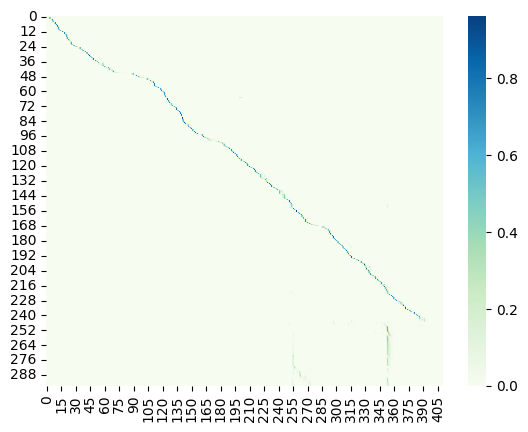

Saved epoch model
Saved best model

Epoch: 20/98


Val:   5%|▍         | 1/22 [00:02<00:58,  2.80s/it, dist=16.5938]

Ground Truth :  I BECAME SOMEWHAT EMBARRASSED FOR I WAS USED TO BEING TAKEN FOR GRANTED BY MY ELDERS
Prediction   :  I BECAME SOME WHAT EMBARRASSED FOR I WAS USED TO BEING TAKEN FORGANTED BY MY ELDERS


Val:   9%|▉         | 2/22 [00:05<00:55,  2.77s/it, dist=18.3125]

Ground Truth :  I NEVER SAW PEOPLE LIKE THE SNELLINGS FOR POSSESSING RELATIVES IN ALL SORTS OF LINES
Prediction   :  I NEVER SAW A PEOPLE LIKE THE SNOWLINGS FOR POSSESSING RELITIVES IN ALSO SOUTH OF LINES


Val:  14%|█▎        | 3/22 [00:08<00:54,  2.88s/it, dist=18.8932]

Ground Truth :  SHE STOPPED WITH HER HAND ON THE LATCH OF THE WILSONS DOOR TO STILL HER BEATING HEART AND LISTENED TO THE HUSHED QUIET WITHIN
Prediction   :  SHE STOPPED WITH HER HAND ON THE LATCH OF THE WILSON'S DOOR TO STILL HER BEATING HEART AND LISTENED TO THE HUSHED QUIET WITHIN


Val:  18%|█▊        | 4/22 [00:11<00:52,  2.93s/it, dist=18.6602]

Ground Truth :  HERE IS THE SEAT OF THE ORIGIN OF THE FAMOUS ANTITHESIS GOOD AND EVIL POWER AND DANGEROUSNESS ARE ASSUMED TO RESIDE IN THE EVIL A CERTAIN DREADFULNESS SUBTLETY AND STRENGTH WHICH DO NOT ADMIT OF BEING DESPISED
Prediction   :  HERE IS THE SEAT OF THE ORGIN OF THE PLAMES AND TO THIS IS GOOD AND DEEPLE POWER AND DANGEROUS AS RESUMED TO RESIDE IN THE EVIL A CERTAIN DREADFUL ASSULTING STRINGTH WHICH DO NOT HAD MADE HAVE BEEN DESPISED


Val:  23%|██▎       | 5/22 [00:14<00:50,  2.97s/it, dist=18.8391]

Ground Truth :  VARIOUS DISHES ARE FREQUENTLY ORNAMENTED AND GARNISHED WITH ITS GRACEFUL LEAVES AND THESE ARE SOMETIMES BOILED IN SOUPS ALTHOUGH IT IS MORE USUALLY CONFINED IN ENGLISH COOKERY TO THE MACKEREL SAUCE AS HERE GIVEN
Prediction   :  VERIOUS DISHES ARE FREQUENTLY ORNAMENTED AND GUARNISHED WITH ITS GRACEFUL LEAVES AND THESE ARE SOMETIMES BOY THAN SUITS ALTHOUGH IT IS MORE USUALLY CONFINED IN ENGLISH GOOGRY TO THE MACKROSS OF AS HERE GIVEN


Val:  27%|██▋       | 6/22 [00:17<00:47,  2.96s/it, dist=19.5065]

Ground Truth :  AND IF YOU HAVE TIME IT WOULD BE A GREAT SERVICE TO TRANSLATE THE ANALYSES OF THE POEMS WHICH I OMITTED
Prediction   :  AND IF YOU HAVE TIME IT WOULD BE A GREAT SERVICE TO TRANSLY THE AMALICIES OF THE POND WHICH I AM IT


Val:  32%|███▏      | 7/22 [00:20<00:45,  3.04s/it, dist=20.0960]

Ground Truth :  YES HILDA I KNOW THAT HE SAID SIMPLY
Prediction   :  YES HILLOW I KNOW THAT HE SAID SIMPLY


Val:  36%|███▋      | 8/22 [00:23<00:41,  2.94s/it, dist=19.5781]

Ground Truth :  HE IS JUST MARRIED YOU KNOW IS HE SAID BURGESS
Prediction   :  HE IS JUST MARRIED YOU KNOW YES HE SAID BURGES


Val:  41%|████      | 9/22 [00:26<00:38,  2.93s/it, dist=19.6849]

Ground Truth :  IT IS LINED WITH EMERALD ALGAE AND MOSSES AND SHADED WITH ALDER WILLOW AND THORN BUSHES WHICH GIVE IT A FINE SETTING
Prediction   :  IT IS LINE WITH EMBLE ALGEY AND MOSSES AND SHADED WITH ELDER WELL AND FORM BUSHES WHICH GIVE IT A FINE SETTING


Val:  45%|████▌     | 10/22 [00:29<00:35,  2.93s/it, dist=19.3641]

Ground Truth :  IN THAT CASE YOU WILL FIND ME A PROUD IMPETUOUS AMBITIOUS FELLOW CHRISTIE AND HOW WILL THAT SUIT
Prediction   :  IN THAT CASE YOU AFFIND ME APROWED IMPEDULOUS AMBITIOUS FELLOW CRISTY A TALE WILL THAT SURE


Val:  50%|█████     | 11/22 [00:32<00:31,  2.87s/it, dist=19.5298]

Ground Truth :  A SNAKE OF HIS SIZE IN FIGHTING TRIM WOULD BE MORE THAN ANY BOY COULD HANDLE
Prediction   :  THE SMAKE OF ITS SIZE AND FIGHTING TRIM WOULD BE MORE THAN NEED BLIKE A HANDLE


Val:  55%|█████▍    | 12/22 [00:35<00:29,  2.91s/it, dist=19.5788]

Ground Truth :  ALL THE TIME HIS THOUGHTS WOULD RUN OUT TO HIS HOME AND SEE THE SCENE BEING THEREIN ENACTED
Prediction   :  I LITTLE IN THE SATS WOULD RAN OUT TO HIS HOUND AND SEE THE SEA THE SEATEN BEING BEAR AND INAFTED


Val:  59%|█████▉    | 13/22 [00:38<00:26,  2.99s/it, dist=19.7650]

Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEET WATER AS THEY CALLED HIM WAS I HAVE SENSENTERESTOOD ONE OF HE IS MURTERED JASE AND MORE OR LESS OF A FAVORITE


Val:  64%|██████▎   | 14/22 [00:41<00:23,  2.93s/it, dist=19.5100]

Ground Truth :  OH BARTLEY WHAT AM I TO DO
Prediction   :  OH BARLY WHAT AN I TO TOO


Val:  68%|██████▊   | 15/22 [00:43<00:19,  2.85s/it, dist=19.3745]

Ground Truth :  A MAN WAS LOOKING IN FROM THE CORRIDOR BEHIND AT THE FOUR PERSONS WE WERE JUST DISCUSSING
Prediction   :  A MAN WAS LOOKING HIM FROM THE CORDER BEHIND AT THE FORE PERSONS WE WERE JUST DISCUSSING


Val:  73%|███████▎  | 16/22 [00:46<00:17,  2.92s/it, dist=19.5811]

Ground Truth :  THE MEAL ENDED
Prediction   :  THE MEAL ENDED


Val:  77%|███████▋  | 17/22 [00:49<00:14,  2.96s/it, dist=19.4430]

Ground Truth :  MISS WOODLEY OBEDIENTLY SAT DOWN AND THOUGH HER THOUGHTS AND HEART WERE IN THE CHAMBER OF HER FRIEND SHE NEVER MARKED BY ONE IMPERTINENT WORD OR BY ONE LINE OF HER FACE THE RESTRAINT SHE SUFFERED
Prediction   :  WHO IS WITH LEADILY ILLEDIATELY SAT DOWN AND THOUGH WERE THOUGHTS AND HEART WHERE IN THE CHAMBER OF HER FRIEND SHE NEVER MARCHED BY ONE IMPRINTENED WORD OR BY ONE LINE OF HER FACE THE RESTRAINED SHE SUFFERED


Val:  82%|████████▏ | 18/22 [00:52<00:11,  2.86s/it, dist=19.3034]

Ground Truth :  HE HAD HARDLY UTTERED THE WORDS WHEN THE BOY FLUNG HIMSELF BENEATH THE LOG
Prediction   :  HE HAD HARDLY UTTERED THE WORDS WHEN THE BOY FLUNG HIMSELF BENEATH THE LOW


Val:  86%|████████▋ | 19/22 [00:55<00:08,  2.86s/it, dist=19.6061]

Ground Truth :  DEAD SAID DOCTOR MACKLEWAIN
Prediction   :  DEAD SAID DOCTOR MACKALANE


Val:  91%|█████████ | 20/22 [00:58<00:05,  2.83s/it, dist=19.5773]

Ground Truth :  I COULD NOT HELP MY FRIEND
Prediction   :  I COULD NOT HELD MY FRIEND


Val:  95%|█████████▌| 21/22 [01:01<00:02,  2.88s/it, dist=19.5379]

Ground Truth :  BY HIS DEFAULT SHORT WHILE HE SOJOURNED HERE BY HIS DEFAULT TO WEEPING AND TO TOIL HE CHANGED HIS INNOCENT LAUGHTER AND SWEET PLAY
Prediction   :  I HAS DEFALT SHORE WHIRE HE SAID JURNED HERE BY HIS DEFALSE TO WE BEING ENTERED HORIL HE CHANGED HIS INNOCENT WERE AFTER AND SWEET PLAY


Ground Truth :  THIS GARISH DISPLAY OF MIRRORS AND ELABORATE DECORATION OF CEILING AND PILLARS GIVES IT THE APPEARANCE OF THE ABODE OF SATURNALIA BUT DECORUM IS THE RULE AMONG THE PATRONS
Prediction   :  THIS GARESHED DISPLAYED NEARERS AND ALIBERATE DECARATION OF SEEILING IMPOLERS GIVES AT THE APPEARANCE OF THE ABOLE OF SATRINALIA BUT TO CORRON IS THE RULE AMONG THE PATRENCE
Train loss: 0.9771908417410915 Train Perplexity: 2.676429746396873 lr:  0.0001
Validation dist:  19.740767045454547


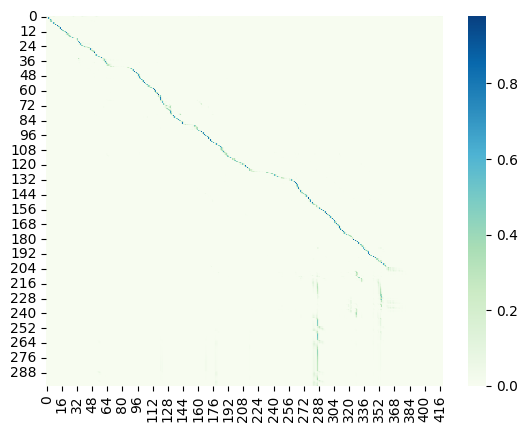

Saved epoch model
Saved best model

Epoch: 21/98


Val:   5%|▍         | 1/22 [00:02<01:00,  2.87s/it, dist=22.2422]

Ground Truth :  AH FATHER SAID HANSEL I AM LOOKING AT MY WHITE CAT SITTING UPON THE ROOF OF THE HOUSE AND TRYING TO SAY GOOD BYE
Prediction   :  AH FATHER SAID HANDSO I AM LOOKING AT MY WAIT CAT SITTING UPON THE ROOT CAT SITTING UPON THE ROOT OF THE HOUSE AND TRIED TO SAY TO BY


Val:   9%|▉         | 2/22 [00:05<00:57,  2.87s/it, dist=20.3789]

Ground Truth :  SCARCELY HAD HE COME TO THE WOOD WHEN ALL THE TREES AND THORNS WHICH HAD MADE SUCH AN IMPENETRABLE THICKET OPENED ON ONE SIDE AND THE OTHER TO OFFER HIM A PATH
Prediction   :  SCARCELY HAD HE COME TO THE WOOD WHEN ALL THE TREES AND SORROWS WHICH HAD MADE SUCH AN IMPENERATIBLE THINKING OPEN DONE WORN SIDE IN THE OTHER TO AFFER IN THE PATH


Val:  14%|█▎        | 3/22 [00:08<00:54,  2.88s/it, dist=20.9557]

Ground Truth :  WE DID NOT IT MUST HAVE COME TO LIFE SOME TIME DURING THE NIGHT AND DUG ITS WAY OUT LAUGHED TAD
Prediction   :  WE DID NOT THE MUST OF COME TO LIVE SOMETIME DURING THE ITE INDILITS WAY UP LEFT HEAD


Val:  18%|█▊        | 4/22 [00:11<00:53,  2.96s/it, dist=21.6055]

Ground Truth :  MODE PUT THE WHOLE OF THE INGREDIENTS INTO A BOTTLE AND LET IT REMAIN FOR A FORTNIGHT IN A WARM PLACE OCCASIONALLY SHAKING UP THE CONTENTS
Prediction   :  MODE BUT THE WHOLE OF THE INGREEDIANCE INTO A BUTTLE AND LET IT REMAINED FOR A FORTNIGHT IN A WARM PLACE OCCASIONALLY SHAKING UP THE CONTENTS


Val:  23%|██▎       | 5/22 [00:14<00:48,  2.82s/it, dist=21.0156]

Ground Truth :  IT IS LINED WITH EMERALD ALGAE AND MOSSES AND SHADED WITH ALDER WILLOW AND THORN BUSHES WHICH GIVE IT A FINE SETTING
Prediction   :  IT IS LINE WITH EMBLE ALGEY AND MOSSES AND SHEDED WITH ELDER WILL AND FORM BUSHES WHICH GIVEN A FINE SETTING


Val:  27%|██▋       | 6/22 [00:17<00:46,  2.89s/it, dist=20.9609]

Ground Truth :  YOU'RE A DISMISSED OFFICER OF THE GOVERNMENT SIR
Prediction   :  YOU ARE DISMISSED OPPOSER IN THE GOVERNMENT SIR


Val:  32%|███▏      | 7/22 [00:20<00:43,  2.92s/it, dist=20.7121]

Ground Truth :  WE SHOULD LIKE ABOVE ALL THINGS SAID DEUCALION TO SEE THIS LAND FULL OF PEOPLE ONCE MORE FOR WITHOUT NEIGHBORS AND FRIENDS THE WORLD IS A VERY LONELY PLACE INDEED
Prediction   :  WE SHOULD LIKE A BOTH ALL THINGS SAID DO CAN IN TO SEE THIS LAND FOOL OF PEOPLE ONCE MORE FOR WAS OUT NAIBERS AND FRIENDS THE WORLD AS A VERY LONELY PLACE INDEED


Val:  36%|███▋      | 8/22 [00:23<00:41,  2.97s/it, dist=20.2383]

Ground Truth :  BEFORE I CONSENTED TO ANSWER THE CHILD'S INQUIRIES I CAME TO AN UNDERSTANDING WITH HER MOTHER
Prediction   :  THE FOREIGN CONSENTED AND SWITH A CHILDS INQUIRIES I CAME TO AN UNDERSTANDING WITH HER MOTHER


Val:  41%|████      | 9/22 [00:25<00:37,  2.85s/it, dist=19.7300]

Ground Truth :  I'VE GIVEN MY ORDERS SIR
Prediction   :  I GIVEN MY ORDER SIR


Val:  45%|████▌     | 10/22 [00:28<00:34,  2.90s/it, dist=19.8039]

Ground Truth :  RETURN TO YOUR PROVINCES AND MAY YOUR PRIVATE VIRTUES REPAIR THE MISCHIEF AND SCANDAL OF YOUR MEETING
Prediction   :  RETURNED YOUR PROVINCES AND BE YOUR PRINTED FOR TEAS REPAIR THE MISCHIEF AND SCANDLE OF YOUR MEATING


Val:  50%|█████     | 11/22 [00:31<00:32,  2.92s/it, dist=19.6847]

Ground Truth :  EVEN FROM A DISTANCE ONE COULD SEE THAT THERE WAS SOMETHING STRANGE ABOUT THIS BOY
Prediction   :  EVEN TO MADISTANCE WANT COULD SEE THAT THERE WAS SOMETHING STRANGE ABOUT THIS BOY


Val:  55%|█████▍    | 12/22 [00:34<00:28,  2.84s/it, dist=19.6439]

Ground Truth :  THIS MODEST SCHOLAR SPOKE NO LANGUAGES SAVE ICELANDIC AND LATIN
Prediction   :  THIS MOTISTALLERS BOOK NO LANGUID IS SAVE I SLANDIC IN LATTEN


Val:  59%|█████▉    | 13/22 [00:37<00:26,  2.91s/it, dist=19.7590]

Ground Truth :  THERE THEY STROVE TO BREAK THE SILVER CORD OF LIFE AND THRUST MY SOUL INTO THE BODY OF A FOUL NIGHT WEIRD THEIR SORCERY SUMMONED UP FROM HELL AH
Prediction   :  THERE THEY STROVE TO BREAT THE SOUL RECORD OF LIFE AND THRUST MY SOUL INTO THE BODY OF A FALL NIGHT WE END THEIR SOURCERY SOME ADOPT FROM HILL AH


Val:  64%|██████▎   | 14/22 [00:40<00:23,  2.95s/it, dist=19.9699]

Ground Truth :  THERE ARE NATURES TOO TO WHOSE SENSE OF JUSTICE THE PRICE EXACTED LOOMS UP MONSTROUSLY ENORMOUS ODIOUS OPPRESSIVE WORRYING HUMILIATING EXTORTIONATE INTOLERABLE THOSE ARE THE FANATICS
Prediction   :  THERE WERE NATURES TOO TO HER SENSE OF JUSTICE THE PRESENT JUST AS THE PRESENT ACT TO LOOSE UP MOSSELY IN ARMOUS ODIOUS A PRESS OF WARIING HE MILLIOTING EXTORTION IT INTORRABLE THERE WAS OTHER FINATICS


Val:  68%|██████▊   | 15/22 [00:43<00:20,  2.92s/it, dist=19.9115]

Ground Truth :  THIS WAS THE OLD ESTABLISHMENT OF URSUS ITS PROPORTIONS AUGMENTED BY SUCCESS AND IMPROVED FROM A WRETCHED BOOTH INTO A THEATRE
Prediction   :  THIS WAS THE ALL THE STABLISHMENT OF HURSTS IT'S PROPORTIONS AUDMENTED BY SUCCESS AND IMPRIVED FROM A RECHANT BOTH INTO WITH THE AITOR


Val:  73%|███████▎  | 16/22 [00:46<00:17,  2.98s/it, dist=19.8472]

Ground Truth :  BOZZLE HAD ALWAYS WAITED UPON HIM WITH A DECENT COAT AND A WELL BRUSHED HAT AND CLEAN SHOES
Prediction   :  BAUSEL HAD ALWAYS WAITED UPON HIM WITH A DEASENT COAT AND A WELL BRUST HAT AND CREAN CHOOSE


Val:  77%|███████▋  | 17/22 [00:49<00:15,  3.02s/it, dist=19.7220]

Ground Truth :  BESIDES WE MUST REMEMBER THAT THEY HAD IN THOSE TIMES MEANS OF PUTTING PATIENTS TO SLEEP AND OF SUPPRESSING ALL SUFFERING ONLY THEN IT WAS CALLED MAGIC WHILE NOW IT IS CALLED ANAESTHESIA
Prediction   :  BESIDES WE MUST REMEMBER THAT THEY HAD IN THOSE TIMES MEANS OF PUTTING PATIENCE TO SLEEP AND OF SUPPRESSING ALL SUFFERING ONLY THEN IT WAS CALLED MAGIC WELL NOW IT IS CALLED AND HIS FEESUA


Val:  82%|████████▏ | 18/22 [00:52<00:11,  2.97s/it, dist=19.7279]

Ground Truth :  THE WAITER OF THE MAGAZZINO CAME TO BE PAID AND OUR CHIEF GAVE HIM WHAT WAS DUE ENJOINING SILENCE UNDER PENALTY OF DEATH
Prediction   :  THE WATER OF THE MIGHT AS YOU KNOW CAME TO BE PAID AND OUR CHIEF GAVE HIM WHAT WAS DO ENJOYNING SILENCE UNDER PENALTY OF DEATH


Val:  86%|████████▋ | 19/22 [00:55<00:08,  2.97s/it, dist=19.7138]

Ground Truth :  SOME OF THE PREPARATIONS OF MAIZE FLOUR ARE VERY GOOD AND WHEN PARTAKEN IN MODERATION SUITABLE FOOD FOR ALMOST EVERYBODY
Prediction   :  SOME OF THE PREPARATIONS OF MACE FLOWER ARE VERY GOOD AND WHEN PARTAKEN IN MODERATION SUITABLE FOOD FOR ALMOST EVERY BODY


Val:  91%|█████████ | 20/22 [00:58<00:05,  2.98s/it, dist=19.6273]

Ground Truth :  I FOLLOWED WITH THE SPADE OVER MY SHOULDER DRAGGING MY SNAKE
Prediction   :  I FOLLOWED WITH A SPAID OVER MY SHOULDER DRAGGING MICE SNAKE


Val:  95%|█████████▌| 21/22 [01:01<00:03,  3.02s/it, dist=19.6261]

Ground Truth :  OUR HONOR IS THE GUARANTEE FOR HIS SAFETY SO LONG AS HE IS WITHIN THE CAMP
Prediction   :  OUR HONOR AS THE GURRENT TEATH FOR HER SAFETY SO LONG AS HIS WITHIN THE CAMP


Ground Truth :  I SHOULD LIKE TO SEE THE DESK YOU SPEAK OF AND THE SPOT WHERE SHE FELL
Prediction   :  I SHOULD LIKE TO SEE THE DESPAT WHERE SHE FELL
Train loss: 0.9673960497561057 Train Perplexity: 2.64913304718086 lr:  0.0001
Validation dist:  19.55826231060606


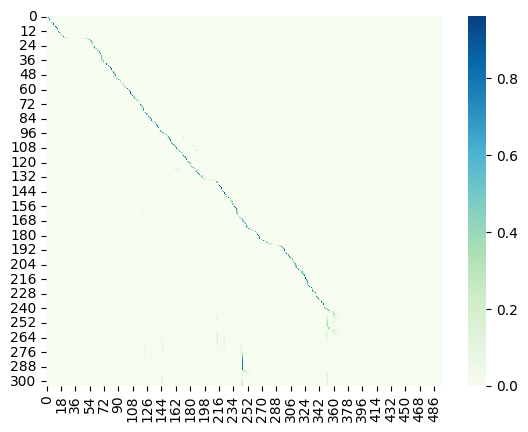

Saved epoch model
Saved best model

Epoch: 22/98


Val:   5%|▍         | 1/22 [00:02<01:02,  2.96s/it, dist=23.5781]

Ground Truth :  BUT IF THE EMPERORS HAD BECOME CHRISTIAN THE EMPIRE HAD NOT
Prediction   :  BUT IF THE EMPERORS HAD BECOME CHRISTIAN THE EMPIRE HAD NOT


Val:   9%|▉         | 2/22 [00:05<00:55,  2.78s/it, dist=19.9922]

Ground Truth :  SOMEONE SNIGGERED
Prediction   :  SOME ON SNAGGERED


Val:  14%|█▎        | 3/22 [00:08<00:54,  2.87s/it, dist=20.2500]

Ground Truth :  HE PASSED THROUGH ONE APARTMENT AFTER ANOTHER WHERE WERE LADIES AND GENTLEMEN ASLEEP IN THEIR CHAIRS OR STANDING
Prediction   :  HE PASSED THROUGH ONE A PARTMENT AFTER ANOTHER WHERE WERE LADIES AND GENTLEMEN ASLEEP IN NO CHAIRS OR STANDING


Val:  18%|█▊        | 4/22 [00:11<00:50,  2.82s/it, dist=20.0840]

Ground Truth :  HAVING RETURNED TO THE ROYAL CAVERN KALIKO FIRST POUNDED THE GONG AND THEN SAT IN THE THRONE WEARING RUGGEDO'S DISCARDED RUBY CROWN AND HOLDING IN HIS HAND THE SCEPTRE WHICH RUGGEDO HAD SO OFTEN THROWN AT HIS HEAD
Prediction   :  HEAVING RETURNED TO THE WORLD CAVERING CALICAL FIRST POUNDED THE GORM AND SAID IN LOST ROOM WEARING LIGHTED OS DISCOURATED GREW BE CROWN AND FOLLING IN HIS HAND TO SUPPER WHICH WERE GOOD WHO HAD SO LOCKED HIMSER ON AT HIS HEAD


Val:  23%|██▎       | 5/22 [00:14<00:48,  2.85s/it, dist=19.7000]

Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SACARING SNABRILY MAN AND TO SPOIL WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECTY FEATSILY


Val:  27%|██▋       | 6/22 [00:16<00:44,  2.80s/it, dist=19.4544]

Ground Truth :  AND SHE GOT UP AND PUT HER HEAD INTO THE OVEN
Prediction   :  AND SHE GOT UP AND PUT HER HEAD INTO THE OTHER


Val:  32%|███▏      | 7/22 [00:20<00:43,  2.89s/it, dist=19.6808]

Ground Truth :  THEY WERE RUN OUT OF THEIR VILLAGE
Prediction   :  THEY WERE ONE OUT OF THEIR VILLAGE


Val:  36%|███▋      | 8/22 [00:22<00:38,  2.78s/it, dist=19.2773]

Ground Truth :  AND THEREWITHAL SUCH A BEWILDERMENT POSSESS'D ME THAT I SHUT MINE EYES FOR PEACE AND IN MY BRAIN DID CEASE ORDER OF THOUGHT AND EVERY HEALTHFUL THING
Prediction   :  AND THERE WITHOUT SUCH A BEWILDER ME POSSESSED ME BUT I SHUT MY MISE PROPEACE IN IN MY BRING DID CEASE OR HER THOUGHT AND EVERY HELP HOLTHING


Val:  41%|████      | 9/22 [00:25<00:37,  2.87s/it, dist=19.3611]

Ground Truth :  AT LAST THE MAJOR SAID MY FRIENDS KEEP THAT TO THE LAST MOMENT
Prediction   :  AT LAST THE MAID HER SAID MY FRIENDS HEAT THAT TO THE LAST MOMENT


Val:  45%|████▌     | 10/22 [00:28<00:35,  2.92s/it, dist=19.4680]

Ground Truth :  NO LETTER HAD COME NO WORD OF ANY KIND AND YET HERE IT WAS LATE IN THE EVENING AND SHE HAD AGREED TO MEET HIM THAT MORNING
Prediction   :  NO LETTER HAD COME NO WORD OF ANY KIND AND YET CURIOD WISE LATE IN THE EVENING AND SHE HAD GREAT TO MEET HIM THAT MORNING


Val:  50%|█████     | 11/22 [00:31<00:33,  3.00s/it, dist=19.4219]

Ground Truth :  WHEN HIS PUBLIC SERVICES WERE FINISHED HE STARTED IN COMPANY WITH HIS WIFE SON JESSE AND A FEW FRIENDS
Prediction   :  WHEN HIS PUBLIC SERVICES WERE PENISHED HE STARTED IN COMPANY WITH HIS WIFE SUN JUSTY IN A FEW FRIENDS


Val:  55%|█████▍    | 12/22 [00:34<00:28,  2.89s/it, dist=19.1458]

Ground Truth :  HE ADDED SYDNEY'S ADDRESS IN A POSTSCRIPT AND DISPATCHED HIS LETTER THAT EVENING
Prediction   :  HE HAD IT SUDDENESS ADDRESS IN A POST GRIPT AND DESPATCHED HIS LETTER THAT EVENING


Val:  59%|█████▉    | 13/22 [00:37<00:25,  2.81s/it, dist=18.7776]

Ground Truth :  THE PLACARD GWYNPLAINE THE LAUGHING MAN TAKEN FROM ITS NAIL IN THE GREEN BOX WAS HUNG UP CLOSE TO THE SIGN OF THE INN
Prediction   :  THE PLACKERED WHEN PLAINED THE LAUGHING MAN TAKEN FROM ITS NAIL IN THE GREEN BOX WAS HOW THAT CLOSE TO THE SIGN OF THE IN


Val:  64%|██████▎   | 14/22 [00:40<00:23,  2.90s/it, dist=18.8583]

Ground Truth :  HI THERE HISSED LUMPY FILLED WITH INDIGNATION THAT ANYONE SHOULD ATTEMPT TO MOUNT A PONY FROM THE RIGHT SIDE
Prediction   :  HEIGHT THERE HIS SPLENTY DILL WITH THE DEMATION THAT IN YOU WENT SHE DETEMPTIMENT UPON YOU FROM THE RIGHT SIDE


Val:  68%|██████▊   | 15/22 [00:42<00:19,  2.78s/it, dist=18.7693]

Ground Truth :  IT IS A NATIVE OF PORTUGAL AND WHEN ITS LEAVES ARE USED AS A SEASONING HERB THEY HAVE AN AGREEABLE AROMATIC FLAVOUR
Prediction   :  IT IS A NATIVE OF PORTUAGLE AND WHEN ITS LEAVES TO USED AS A SISTING EARB THEY HAVE AN AGREEABLE HEROMATIC LAVER


Val:  73%|███████▎  | 16/22 [00:45<00:16,  2.75s/it, dist=18.6230]

Ground Truth :  IF THE ORIGINAL IS STILL IN THE WORLD I THINK HE MIGHT DEFY THE SUN TO MAKE HIM LOOK STERN AND HARD
Prediction   :  IF YOU RIGINAL AS STONE THE WORLD I THINK HE MIGHT DEFIVE THE SON TO MAKE HIM LOOKS DEARN AND HARD IN


Val:  77%|███████▋  | 17/22 [00:48<00:13,  2.76s/it, dist=18.5308]

Ground Truth :  EXTERMINATE WITH ME THE HERETICS AND WITH YOU I WILL EXTERMINATE THE PERSIANS
Prediction   :  EXTERMIT WITH ME THE HEARTICS AND WITH YOU I WILL EXTERMINE IT THE PERSONS


Val:  82%|████████▏ | 18/22 [00:50<00:10,  2.69s/it, dist=18.3889]

Ground Truth :  FOR SHE HAD ONLY THE FOUNDATION LAID CRISS CROSS AS THE MAGPIE HAD SHOWN HER
Prediction   :  FOR SHE HAD ONLY THE FOUNDATIONLY CRISCROSS AS THE MAID BY HAVE SHOWN HER


Val:  86%|████████▋ | 19/22 [00:53<00:08,  2.72s/it, dist=18.5596]

Ground Truth :  THE DAILY NEWSCASTS FROM TERRA SHOWED A CORRESPONDING SHIFT IN INTEREST AT HOME
Prediction   :  THE DAILY NEWS CAST FROM TERROR SHOWED A CORRESPONDING SHIFTING INTEREST AT HOME


Val:  91%|█████████ | 20/22 [00:56<00:05,  2.80s/it, dist=18.3832]

Ground Truth :  TOM NODDED UNHAPPILY
Prediction   :  TALL NODDED UNHAPPILY


Val:  95%|█████████▌| 21/22 [00:59<00:02,  2.86s/it, dist=18.6008]

Ground Truth :  THAT DIVINE WORD WHO IS THE LIGHT WHO LIGHTETH EVERY MAN WHICH COMETH INTO THE WORLD HAD AWAKENED IN THE HEART OF MANKIND A MORAL CRAVING NEVER BEFORE FELT IN ANY STRENGTH EXCEPT BY A FEW ISOLATED PHILOSOPHERS OR PROPHETS
Prediction   :  THAT DIVINE WORD WHO IS THE LIGHT WHO LIGHT IT EVERY MAN WHICH COME INTO THE WORLD HOW TO WAKEN IN THE HEART OF MAN KIND OF MORAL CRAVING NEVER BEFORE FELT IN ANY STRENGTH EXCEPT BY A FEW ISLATED FLOSS FERSOR PROFITS


Ground Truth :  THE LADY IS NOT THE MOTHER OF THE BOYS BUT THEIR AUNT
Prediction   :  THE LADIES NOT THE MOTHER OF THE BOYS BUT THEIR ANNT
Train loss: 0.9559633812027661 Train Perplexity: 2.6204111522623244 lr:  0.0001
Validation dist:  18.53108428030303


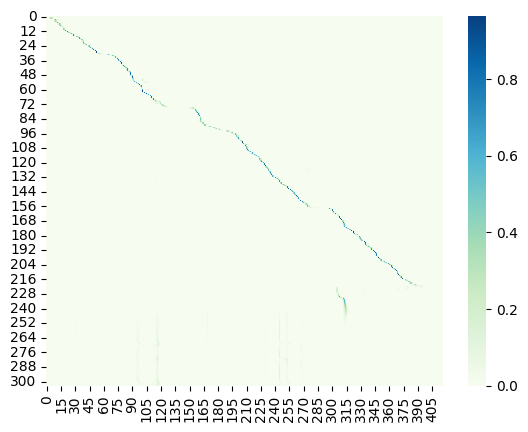

Saved epoch model
Saved best model

Epoch: 23/98


Val:   5%|▍         | 1/22 [00:03<01:04,  3.07s/it, dist=22.4297]

Ground Truth :  THE QUEEN GAZED UPON OUR FRIENDS WITH EVIDENT INTEREST
Prediction   :  THE QUEEN GAZED UPON HER FRIENDS WITHOUT IT INTEREST


Val:   9%|▉         | 2/22 [00:05<00:59,  2.98s/it, dist=19.7578]

Ground Truth :  HE IS OLD AS WELL AS POOR SHE SAID
Prediction   :  HE IS OLD AS WELL AS POOR SHE SAID


Val:  14%|█▎        | 3/22 [00:08<00:55,  2.90s/it, dist=19.6120]

Ground Truth :  BE THE RESULTS HOWEVER WHAT THEY MIGHT RANDAL COULD SEE BUT ONE PLAIN COURSE BEFORE HIM NOW
Prediction   :  THE THE RESULTS HOWEVER WHAT THEY MIGHT RENDLE COULD SEE BUT ONE PLAIN COURSE BEFORE HIM NOW


Val:  18%|█▊        | 4/22 [00:11<00:53,  2.97s/it, dist=19.6348]

Ground Truth :  THE HIGHEST INSTINCT FOR PURITY PLACES HIM WHO IS AFFECTED WITH IT IN THE MOST EXTRAORDINARY AND DANGEROUS ISOLATION AS A SAINT FOR IT IS JUST HOLINESS THE HIGHEST SPIRITUALIZATION OF THE INSTINCT IN QUESTION
Prediction   :  THE HIGHEST INSTINCT FOR PURITY PLACES HIM WHO WAS AFFECTED WITH IT IN THE MOST EXTRAORDINARY AND DAIN TO RESISE ELATION AS A SEEMED FOR IT HIS JUST HOLDING US THE HIGHEST SPIRITUALIZATION OF THE INSTINCTING QUESTION


Val:  23%|██▎       | 5/22 [00:15<00:51,  3.04s/it, dist=19.9406]

Ground Truth :  I SAW BUT FEW INHABITANTS DURING MY EXCURSION BUT I MET A CROWD ON THE BEACH DRYING SALTING AND LOADING CODFISH THE PRINCIPAL ARTICLE OF EXPORTATION
Prediction   :  I SAW THAT FEW IN HABIT IN STURN MY EXCURSION BUT IN MET A CROWD ON THE BEACH DRYING SALTING AND LODING CAUGHT FISH THE PRINCIPAL ARTICLE OF EXPERTATION


Val:  27%|██▋       | 6/22 [00:17<00:48,  3.01s/it, dist=19.0938]

Ground Truth :  NOT HAVING HEARD FROM CAPTAIN BENNYDECK FOR SOME LITTLE TIME RANDAL THOUGHT IT DESIRABLE IN SYDNEY'S INTERESTS TO MAKE INQUIRIES AT HIS CLUB
Prediction   :  NOT HAVING HEARD FROM CAPTAIN BENEATH FOR SOME LITTLE TIME RENDLE THOUGHT IT DESIRABLE IN SIT THESE INTEREST TO MAKE INQUIRIES AT HIS CLUB


Val:  32%|███▏      | 7/22 [00:20<00:44,  2.98s/it, dist=18.9107]

Ground Truth :  COSETTE ON HER SIDE HAD ALSO UNKNOWN TO HERSELF BECOME ANOTHER BEING POOR LITTLE THING
Prediction   :  COSETTE ON HER SIDE HAD ALSO I KNOWN TO HERSELF BECAUME ANOTHER BE IN POOR LITTLE THING


Val:  36%|███▋      | 8/22 [00:23<00:40,  2.88s/it, dist=18.3809]

Ground Truth :  YOUR CRY AND THE GRIP OF YOUR FINGERS BROUGHT ME BACK BUT I AM GOING FAST
Prediction   :  YOU A CRY AND THE GROUP OF YOUR FINGERS BOUGHT BE BACK BUT I AM GOING FAST


Val:  41%|████      | 9/22 [00:26<00:38,  2.96s/it, dist=18.3047]

Ground Truth :  BLESSED AM I HERE NOW MY GOD AND BLESSED SHALL I BE THERE THEN
Prediction   :  BLUST IM I HEAR NOW MY GOD AND BLESS SHELL I BE THERE THEN


Val:  45%|████▌     | 10/22 [00:29<00:35,  2.97s/it, dist=18.1703]

Ground Truth :  THEN THERE WAS SILENCE THEN A SIGH AND THE SOUND OF LIGHT MOVING FEET ON THE GRAVEL
Prediction   :  THEN THERE WAS SILENCE THE NASIDE AND THE SOUND OF LIGHT MOVING FEET ON THE GRATTLE


Val:  50%|█████     | 11/22 [00:32<00:32,  2.99s/it, dist=18.1229]

Ground Truth :  THROUGHOUT THIS CENTURY THE POWER OF THE CHURCH WAS CONSTANTLY ON THE INCREASE AND IS VISIBLE IN MANY IMPORTANT CHANGES
Prediction   :  HE RATHER CENTURY THE POWER OF THE CHURCH WAS CONSTANTLY UNINCREASE AND HIS VISIBLE IN MANY IMPORTANT CHANGES


Val:  55%|█████▍    | 12/22 [00:35<00:30,  3.02s/it, dist=18.1361]

Ground Truth :  I FELT THAT IN MY FIRST PROFESSION AS I WAS NOT BLESSED WITH THE VOCATION NECESSARY TO IT I SHOULD HAVE SUCCEEDED ONLY BY DINT OF HYPOCRISY AND I SHOULD HAVE BEEN DESPICABLE IN MY OWN ESTIMATION EVEN IF I HAD SEEN THE PURPLE MANTLE ON MY SHOULDERS FOR THE GREATEST DIGNITIES CANNOT SILENCE A MAN'S OWN CONSCIENCE
Prediction   :  I FELT THAT IN MY FIRST PROFESSION AS I WAS NOT LAST WITH THE VOCATION NECESSARY TO IT I SHOULD HAVE SUCCEEDED ONLY BY DID TO CAPACY AND I SHOULD HAVE BEEN DISPICABLE IN MY HOLDINESTIMATION EVEN IF I HAD SEE IN THE PURPORANTAL OF MY SHOULDERS FOR THE GREAT ASTIGNITIES CANNOT SILENCE A MAN'S OWN COUNTESS


Val:  59%|█████▉    | 13/22 [00:38<00:27,  3.01s/it, dist=18.1412]

Ground Truth :  HE HAS THE STRANGEST FITS AT TIMES
Prediction   :  HE IS THE STRANGES FIPS AT TIMES


Val:  64%|██████▎   | 14/22 [00:41<00:23,  2.89s/it, dist=17.9202]

Ground Truth :  I KNOW I AM JUST AWFUL JIM I WAS SO SCARED
Prediction   :  I KNOW IMPSED AWFUL GENILE WAS SO SPEARED


Val:  68%|██████▊   | 15/22 [00:44<00:20,  2.94s/it, dist=18.0635]

Ground Truth :  YOU SHALL HEAR HOW MY DIVORCED DAUGHTER AND MY POOR LITTLE GRANDCHILD WERE TREATED AT SANDYSEAL AFTER YOU LEFT US
Prediction   :  YOU SHALL HERE HOW MY DEVORE STARTER AND MY POOR LITTLE GRANDCHILD WERE TREATED AT SANDY SEAL AFTER YOU LEFT US


Val:  73%|███████▎  | 16/22 [00:47<00:17,  2.96s/it, dist=18.1763]

Ground Truth :  HANSEL THOUGHT THE ROOF TASTED VERY NICE AND SO HE TORE OFF A GREAT PIECE WHILE GRETHEL BROKE A LARGE ROUND PANE OUT OF THE WINDOW AND SAT DOWN QUITE CONTENTEDLY
Prediction   :  HANCELL THOUGHT THE RIVE TASTED VERY MICE AND SO HE TOWARD OFF A GREAT PEACE WELL RELLED ROUGH A LARGE ROUND PAIN OUT OF THE WINDOW AND SAT DOWN QUITE CONTENTEDLY


Val:  77%|███████▋  | 17/22 [00:50<00:14,  2.93s/it, dist=18.0506]

Ground Truth :  THE WHOLE OF EXISTENCE RESEMBLES A LETTER MODIFIED IN THE POSTSCRIPT
Prediction   :  THE WHOLE OF EXISTENCE RESEMBLES A LETTER MURDERFIED IN THE POST CRIPT


Val:  82%|████████▏ | 18/22 [00:53<00:11,  2.85s/it, dist=18.0139]

Ground Truth :  PETER TOLD HIS TROUBLES TO MISTER SHIMERDA HE WAS UNABLE TO MEET A NOTE WHICH FELL DUE ON THE FIRST OF NOVEMBER HAD TO PAY AN EXORBITANT BONUS ON RENEWING IT AND TO GIVE A MORTGAGE ON HIS PIGS AND HORSES AND EVEN HIS MILK COW
Prediction   :  PETER TOLD HIS TROUBLES TO MISTER SHIMARITO HE WAS UNABLE TO MEET A NOTE WHICH FELL DO ON THE FIRST OF GOVERNMER HAD DEPAINING HIS ORIGIN BONES ON REKEWING IT AND TO GIVE A MORE TO JUNNE'S PAGE AND HORSES AND EVEN HIS NO COW


Val:  86%|████████▋ | 19/22 [00:55<00:08,  2.78s/it, dist=17.9030]

Ground Truth :  THEN ALICE BROKE THE SILENCE BY SAYING
Prediction   :  THEN ALL IS BROKE THE SILENCE BY SEEING


Val:  91%|█████████ | 20/22 [00:58<00:05,  2.85s/it, dist=17.8445]

Ground Truth :  A YANKEE ALWAYS SAYS NAGER
Prediction   :  I AND HE ALWAYS AS NIGHTER


Val:  95%|█████████▌| 21/22 [01:01<00:02,  2.83s/it, dist=17.9788]

Ground Truth :  BUT PUT IT ON THE TABLE IN THE CORNER OF THE PASSAGE
Prediction   :  BUT PUT IT ON THE TABLE IN THE CORNER OF THE PASSAGE


Ground Truth :  LIGE QUICKLY MADE FAST THE LINE TO A TREE
Prediction   :  LIES QUICKLY MAKE FAST THE LINE DOING TO TREE
Train loss: 0.957146293913837 Train Perplexity: 2.624691400827314 lr:  0.0001
Validation dist:  18.255516098484847


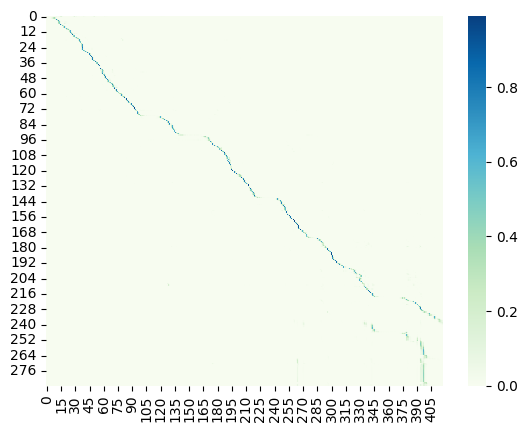

Saved epoch model
Saved best model

Epoch: 24/98


Val:   5%|▍         | 1/22 [00:02<00:54,  2.58s/it, dist=15.4688]

Ground Truth :  THE OLD WOMAN BEHAVED VERY KINDLY TO THEM BUT IN REALITY SHE WAS A WICKED OLD WITCH WHO WAY LAID CHILDREN AND BUILT THE BREADHOUSE IN ORDER TO ENTICE THEM IN BUT AS SOON AS THEY WERE IN HER POWER SHE KILLED THEM COOKED AND ATE THEM AND MADE A GREAT FESTIVAL OF THE DAY
Prediction   :  THE OLD WOMAN BEHAVE YEARY KINDLY TO THEM BUT IN REALITY SHE WAS OPEN IT OLD WHICH WHO WEALLY CHILDREN AND BUILT THE BREAD HOUSE IN ORDER TO INTRACE THE MEN BUT IS SOON AS THEY WERE IN HER POWER SHE KILLED THEM COULD THEM AN AITH THEM AND MADE A GREAT FEST OF ALL THE DAY


Val:   9%|▉         | 2/22 [00:05<00:55,  2.80s/it, dist=15.0039]

Ground Truth :  I INQUIRED OF GEORGE WITH MY EYES STILL ON THIS FURTIVE WATCHER
Prediction   :  I INQUIRED OF GEORGE WITH MY EYES STILL ON THIS THROAT OF WATCHER


Val:  14%|█▎        | 3/22 [00:08<00:55,  2.90s/it, dist=16.4896]

Ground Truth :  THERE WAS AN EXTRAORDINARY FORCE OF SUGGESTION IN THIS POSTURING
Prediction   :  THERE WAS NOT STORE NORTH FORCE OF SUGGESTION THIS POSTERING


Val:  18%|█▊        | 4/22 [00:11<00:50,  2.81s/it, dist=16.2266]

Ground Truth :  BUT THEY'LL PUT A MAN ON FOR YOU
Prediction   :  BUT THE LITTLE MAN ONS WHO ARE YOU


Val:  23%|██▎       | 5/22 [00:14<00:48,  2.84s/it, dist=16.7203]

Ground Truth :  IN ARISTOCRACIES EVERY MAN HAS ONE SOLE OBJECT WHICH HE UNCEASINGLY PURSUES BUT AMONGST DEMOCRATIC NATIONS THE EXISTENCE OF MAN IS MORE COMPLEX THE SAME MIND WILL ALMOST ALWAYS EMBRACE SEVERAL OBJECTS AT THE SAME TIME AND THESE OBJECTS ARE FREQUENTLY WHOLLY FOREIGN TO EACH OTHER AS IT CANNOT KNOW THEM ALL WELL THE MIND IS READILY SATISFIED WITH IMPERFECT NOTIONS OF EACH
Prediction   :  IN ARSTOCRACIES EVERY MAN AS ONE SO LOOKED WHICH HE UNSEASING ME PERSUISE BUT AMONGST THEM ACREDITINATIONS THE EXISTENCE OF MANAS MORE COMPLEX THE SAME MIND WHO ALMOST OLD LAYS EMBRACE SEVERAL OFTECS AT THE SAME MIND WHO ALMOST OLD AS EMBRACE SEVERAL OFTECS AT THE SAME TIME AND THESE OBTICS ARE FREQUENTLY HOW ME FOR UNTO A CHILDREN HAS IT CANNOT KNOW THEM ALL WELL THE MIND IS READILY SATISFIED WITH IMPERFECT NOTIONS OF EACH


Val:  27%|██▋       | 6/22 [00:17<00:47,  2.96s/it, dist=17.5729]

Ground Truth :  WHEN THEY ARE QUITE HOT DIVIDE THEM LENGTHWISE INTO THREE PUT SOME THIN FLAKES OF GOOD BUTTER BETWEEN THE SLICES PRESS THE ROLLS TOGETHER AND PUT THEM IN THE OVEN FOR A MINUTE OR TWO BUT NOT LONGER OR THE BUTTER WOULD OIL TAKE THEM OUT OF THE OVEN SPREAD THE BUTTER EQUALLY OVER DIVIDE THE ROLLS IN HALF AND PUT THEM ON TO A VERY HOT CLEAN DISH AND SEND THEM INSTANTLY TO TABLE
Prediction   :  WHEN THEY ARE QUITE HIGH DIVIDED THEM LENGTH WISE INTO THREE PUT SOME THEN FLAKS OF GOOD BUTTER BETWEEN THE SLIZES PRESSED THE ROSE TOGETHER AND PUT THEM IN THE OVER THE BUTTER WOULD ALLOW TAKE THE MAN OF THE EVEN SPREAD THE BUTTER EQUALLY OVER DIVE THE ROLS AND HALF AND PUT THEM ALL TO A VERY HOT CLAIM DASH AND SEND THEM INSTANTLY TO TABLE


Val:  32%|███▏      | 7/22 [00:20<00:44,  2.95s/it, dist=17.3862]

Ground Truth :  I KNOW I AM JUST AWFUL JIM I WAS SO SCARED
Prediction   :  I KNOW IMPSON AWFUL GENERAL SO SCARED


Val:  36%|███▋      | 8/22 [00:23<00:41,  2.94s/it, dist=17.6631]

Ground Truth :  WHERE IS MY BROTHER NOW
Prediction   :  WHERE IS NOT BREAD HER NOW


Val:  41%|████      | 9/22 [00:25<00:37,  2.85s/it, dist=18.2092]

Ground Truth :  IT WAS A COMFORT TO HER WHEN SCOLDED BY MISS SIMMONDS TO THINK OF THE DAY WHEN SHE WOULD DRIVE UP TO THE DOOR IN HER OWN CARRIAGE TO ORDER HER GOWNS FROM THE HASTY TEMPERED YET KIND DRESSMAKER
Prediction   :  IT WAS A COMFORT TO HER WHEN SCOLDED BY MISSUMENTS TO THINK OF THE DAY AND SHE WERE DRIVE UP TO THE DOOR IN HER OWN CARRIAGE TO ORDER HER DOWNS FROM THE HEASTY TEMPER YET KIND DRESS MAKER


Val:  45%|████▌     | 10/22 [00:28<00:34,  2.89s/it, dist=18.6422]

Ground Truth :  THE SHRIEKS THAT FOLLOWED MADE EVERYBODY SOBER
Prediction   :  THE SHREEKS THAT FOLLOWED ME EVERYBODY SILBER


Val:  50%|█████     | 11/22 [00:31<00:31,  2.88s/it, dist=18.6562]

Ground Truth :  OTTO WINKED AT ME
Prediction   :  I DON'T WINK TO ME


Val:  55%|█████▍    | 12/22 [00:34<00:29,  2.91s/it, dist=18.4089]

Ground Truth :  I WILL TROUBLE YOU NO FURTHER
Prediction   :  I WILL TROUBLE YOU NO SHORTER


Val:  59%|█████▉    | 13/22 [00:37<00:26,  2.98s/it, dist=18.2085]

Ground Truth :  VERY GOOD YOUR HONOUR SAYS TROKE
Prediction   :  VERY GOOD YOUR HONOR SAYS TROKE


Val:  64%|██████▎   | 14/22 [00:40<00:24,  3.04s/it, dist=18.3677]

Ground Truth :  IT CONSISTS SIMPLY OF A FEW HOUSES NOT WHAT IN ENGLAND OR GERMANY WE SHOULD CALL A HAMLET
Prediction   :  A CONSIST SIMPLY OF A FEW HOUSES NOT WITHIN AN WHEN OR GERALLY WE SHOULD CALL A HAME IT


Val:  68%|██████▊   | 15/22 [00:43<00:21,  3.04s/it, dist=18.2979]

Ground Truth :  YOU SHALL HEAR HOW MY DIVORCED DAUGHTER AND MY POOR LITTLE GRANDCHILD WERE TREATED AT SANDYSEAL AFTER YOU LEFT US
Prediction   :  HE SHALL HERE HOW MY DEVORE STAUDER AND MY POOR LITTLE GRANDSHOW WERE TREATED AT SANDY SEAL AFTER YOU LEFT US


Val:  73%|███████▎  | 16/22 [00:46<00:18,  3.02s/it, dist=18.1929]

Ground Truth :  MOUNT BREMER IS THE MOST NOTED STRONGHOLD OF THE SHEEP IN THE WHOLE SHASTA REGION
Prediction   :  NOT BRUMBER IS THE MOST NOTEST DRAWN OLD OF THE SHEEP IN THE WHOLE SHESTER REGION


Val:  77%|███████▋  | 17/22 [00:49<00:14,  3.00s/it, dist=18.2574]

Ground Truth :  WHAT HAPPIER FUTURE COULD AWAIT HER ESPECIALLY IF SHE JUSTIFIED RANDAL'S PAST EXPERIENCE OF ALL THAT WAS CANDID AND TRUTHFUL IN HER CHARACTER THAN TO BECOME HIS FRIEND'S WIFE
Prediction   :  WHAT HAPPY OR FUTURE COULD AWAIT HER ESPECIALLY SHE JUST OF HOT RANDLES PASSED EXPERIENCE OF ALL THAT WAS CANDED AND TRUTHFUL IN HER CHARACTER THEN TO BECOME HIS FRIENDS WIFE


Val:  82%|████████▏ | 18/22 [00:52<00:11,  2.91s/it, dist=18.0964]

Ground Truth :  HE STAYED AT HIS DESK LONG AFTER ALL OTHERS HAD GONE AND ONLY QUITTED IT WHEN THE NIGHT WATCHMAN ON HIS ROUND PULLED AT THE FRONT DOOR TO SEE IF IT WAS SAFELY LOCKED
Prediction   :  HE SEED OF HIS DASK LONG AFTER ALL OTHERS HAD GONE AND ONLY QUITTED IT WHEN THE NIGHT TO MUCHMENT ON HIS RAN FULL THAT THE FRIENDORE TO SEE FITTER WAS SAIEFLY LOCKED


Val:  86%|████████▋ | 19/22 [00:55<00:08,  2.88s/it, dist=17.9153]

Ground Truth :  I OBEYED IMPLICITLY AND MET YOUR EXCELLENCY
Prediction   :  I OBEYED IMPLICITLY AND MET YOUR EXCELLENCY


Val:  91%|█████████ | 20/22 [00:58<00:05,  2.93s/it, dist=17.9117]

Ground Truth :  THE COURT WAS SPACIOUS WELL PAVED AND PERFECTLY CLEAN THERE BEING PROBABLY ANOTHER ENTRANCE BEHIND THE STABLES FOR REMOVING THE LITTER
Prediction   :  THE QUARTERS THAT SHE SWELL PAVED AND PERFECTLY CLEAN THERE BEING PROBLY ANOTHER ENTERNS BEHIND THE STABLES FOR A LOVING A LETTER


Val:  95%|█████████▌| 21/22 [01:01<00:02,  2.97s/it, dist=17.9174]

Ground Truth :  OH BARTLEY WHAT AM I TO DO
Prediction   :  OH BARLY WHAT A LIGHT TO TWO


Ground Truth :  GRASPING THE POMMEL WITH THE LEFT HAND HE APPEARED TO DIVE HEAD FIRST TOWARD THE GROUND
Prediction   :  REST BE THE PUMBLED WITH THE LET HEAD A HEAPER DED DINED HEAD FIRST TOWARD THE GROUND
Train loss: 0.928377377345423 Train Perplexity: 2.5433253461469985 lr:  0.0001
Validation dist:  17.60904356060606


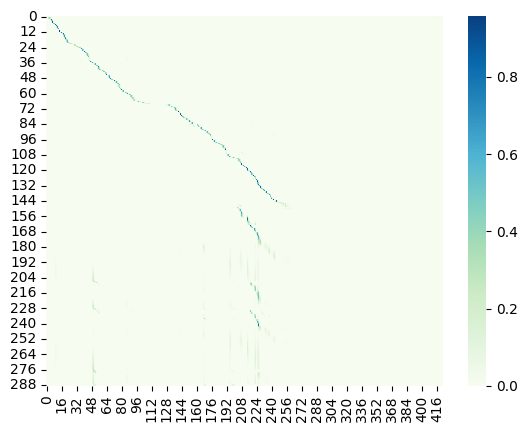

Saved epoch model
Saved best model

Epoch: 25/98


Val:   5%|▍         | 1/22 [00:02<00:53,  2.56s/it, dist=28.7891]

Ground Truth :  LECTURES
Prediction   :  LIKE YEARS


Val:   9%|▉         | 2/22 [00:05<00:58,  2.91s/it, dist=29.2969]

Ground Truth :  HE FANCIED AS HE SAT AT HIS DESK THAT NOTHING WOULD BE DONE FOR A WEEK OR TWO MEANWHILE HE WOULD HAVE TIME TO THINK
Prediction   :  HE BEAUTIES HE SAT IT IS DESK THEY NOTHING WOULD BE DONE FOR OUR EACH OR TO ME MILE HE WOULD HAVE TIME TO THINK


Val:  14%|█▎        | 3/22 [00:08<00:53,  2.82s/it, dist=26.7812]

Ground Truth :  REINCARNATION AND THE CONVERSE OF SPIRITS
Prediction   :  REAL CARNATION IN THE CONGRESS HE SPIRITS


Val:  18%|█▊        | 4/22 [00:11<00:51,  2.84s/it, dist=25.8281]

Ground Truth :  I HOPE YOU'LL LIKE HIM BETTER THAN THE FROST BITTEN OLD DAVID YOU FIRST KNEW AND WERE KIND ENOUGH TO LOVE
Prediction   :  I HOPE YOU LIKE AND BETTER THROUGH THE FROST BIT YOU OLD DAY FOR DO FIRST NEW IN OR KIND ENOUGH TO LOVE


Val:  23%|██▎       | 5/22 [00:14<00:47,  2.81s/it, dist=24.6234]

Ground Truth :  THESE WILDERING PHANTASIES THEN CARRIED ME TO SEE MY LADY DEAD
Prediction   :  THESE WILDERING FAMICIES THAN CARRIED ME TO SEE MY LEADY DEAD


Val:  27%|██▋       | 6/22 [00:16<00:45,  2.84s/it, dist=24.0859]

Ground Truth :  HAVE YOU MANY VISITORS CAPTAIN BURGESS VERY FEW
Prediction   :  HAVE YOU MANY VISITOR SCAPTAIN BURGESS VERY FEW


Val:  32%|███▏      | 7/22 [00:19<00:41,  2.77s/it, dist=25.0357]

Ground Truth :  MARGARET MET JEM WILSON SEVERAL DAYS AFTER HIS BROTHERS WERE SERIOUSLY ILL AND HEARD FROM HIM THE STATE OF THINGS AT HIS HOME
Prediction   :  MARGUERED MATE GENERAL SINCE OF WILDAYS AFTER HIS BROTHERS RESERIES REAL AND HEARD FROM HIM THE STATE OF THEEMS AT HIS HOME


Val:  36%|███▋      | 8/22 [00:22<00:37,  2.70s/it, dist=24.7246]

Ground Truth :  LOOK A LITTLE CLOSER WHILE OUR GUIDE LETS THE LIGHT OF HIS LAMP FALL UPON THE BLACK WALL AT YOUR SIDE
Prediction   :  YOU LITTLE CLOSER WHILE ARE GIED LEFT THE LIGHT OF HIS LARP FALL UPON THE BLACK WALL EIGHT YOUR SIDE


Val:  41%|████      | 9/22 [00:25<00:36,  2.84s/it, dist=24.9436]

Ground Truth :  HE STAYED AT HIS DESK LONG AFTER ALL OTHERS HAD GONE AND ONLY QUITTED IT WHEN THE NIGHT WATCHMAN ON HIS ROUND PULLED AT THE FRONT DOOR TO SEE IF IT WAS SAFELY LOCKED
Prediction   :  HE SEED AT HIS DASK LONG AFTER ALL OTHERS HAD GONE AND ONLY QUITTED IT WHEN THE NIGHT TO MATCHMEN ON HIS RAN FULL THAT THE FRIENDORE TO SEE FIT WAS SEEKLY LOCKED


Val:  45%|████▌     | 10/22 [00:28<00:34,  2.89s/it, dist=25.0648]

Ground Truth :  THE SKY WAS VISIBLE THROUGH SEVERAL GAPING HOLES IN THE ROOF WHICH WAS SAGGING DANGEROUSLY ON ITS SUPPORTING TRUSSES
Prediction   :  THE SKY WAS VISIBLE THROUGH SEVERAL GAPING HALLS IN THE ROOF WHICH WAS SAGGING DANGEROUSLY ON ITS SUPPORTING TRESSES


Val:  50%|█████     | 11/22 [00:31<00:32,  2.99s/it, dist=25.3054]

Ground Truth :  JULIAN'S LAST ATTEMPT TO RESTORE PAGANISM BY IMPERIAL INFLUENCE HAD ONLY PROVED THAT THE OLD FAITH HAD LOST ALL HOLD UPON THE HEARTS OF THE MASSES AT HIS DEATH THE GREAT TIDE WAVE OF NEW OPINION ROLLED ON UNCHECKED AND THE RULERS OF EARTH WERE FAIN TO SWIM WITH THE STREAM TO ACCEPT IN WORDS AT LEAST THE CHURCH'S LAWS AS THEIRS TO ACKNOWLEDGE A KING OF KINGS TO WHOM EVEN THEY OWED HOMAGE AND OBEDIENCE AND TO CALL THEIR OWN SLAVES THEIR POORER BRETHREN AND OFTEN TOO THEIR SPIRITUAL SUPERIORS
Prediction   :  JULIAN'S LAST ATTEMPT TO RESTORE PAGANES AND BY IMPERIAL INFLUENCE HAD ONLY PRUDE THAT THE OLD FAVE HAD LAUGHED ALL HOLD UPON THE HEARTS OF THE MASSES HAD HIS DEATH THE GRADES TIED WAY OF NEW OF A CHEEREAL OF THE RULERS OF EARTH WERE FAINED TO EXAPPED AND WORD AT LEAST THEIR POOR OR BREADER AND OFTEN TO THEIR POOR BREATHEREN AND OFTEN TO THEIR POOR BREATHEREN AND OFTEN TO THEIR POOR BREATHEREN AND OFTEN TO THEIR POOR BREATHEREN AND OFTEN TO THEIR POOR BREATHEREN AND OF

Val:  55%|█████▍    | 12/22 [00:34<00:30,  3.03s/it, dist=25.1380]

Ground Truth :  MINNIE'S FLAT AS THE ONE FLOOR RESIDENT APARTMENTS WERE THEN BEING CALLED WAS IN A PART OF WEST VAN BUREN STREET INHABITED BY FAMILIES OF LABOURERS AND CLERKS MEN WHO HAD COME AND WERE STILL COMING WITH THE RUSH OF POPULATION POURING IN AT THE RATE OF FIFTY THOUSAND A YEAR
Prediction   :  MANY SLAT AS THE WONDFUL ARES OF AT APARTMENTS WERE THEN BEING CALLED WAS IN A PART A WEST MAN BEAR AND STREET IN HAPPITED BY FAMILIES OF LABORERS AND CLERKS MAN HE WOULD COME IN WERE STILL COMING WITH THE RUSSIA POCULATION PORING IN THAT THE READ OF FIFTY THOUSAND THE EAR


Val:  59%|█████▉    | 13/22 [00:37<00:26,  2.91s/it, dist=24.7752]

Ground Truth :  WHAT DOES HE WANT
Prediction   :  HAD DISED HE WALKED


Val:  64%|██████▎   | 14/22 [00:39<00:22,  2.81s/it, dist=24.9079]

Ground Truth :  ADD THE WINE AND IF NECESSARY A SEASONING OF CAYENNE WHEN IT WILL BE READY TO SERVE
Prediction   :  AND THE WINE AND IF NECESSARY HAS SEASING OF CRIAN WHEN IT WILL BE REANY TO SERVE


Val:  68%|██████▊   | 15/22 [00:42<00:20,  2.90s/it, dist=24.9417]

Ground Truth :  IT WAS THE FIRST TIME MISSUS SHIMERDA HAD BEEN TO OUR HOUSE AND SHE RAN ABOUT EXAMINING OUR CARPETS AND CURTAINS AND FURNITURE ALL THE WHILE COMMENTING UPON THEM TO HER DAUGHTER IN AN ENVIOUS COMPLAINING TONE
Prediction   :  IT WAS THE FIRST TIME MISSUS SHUMERED A HAD BEEN TO OUR HOUSE AND SHE RAN ABOUT EXAMINING OUR CARPETS IN CURTAINS IN FURNITURE ALL THE WHILE COMMENTING UPON THEM TO HER DAUGHTER IN AN INVIEST COMPLAINING TONE


Val:  73%|███████▎  | 16/22 [00:45<00:17,  2.93s/it, dist=25.1587]

Ground Truth :  THE PEOPLE MUST WAIT OUTSIDE FOR THERE IS NO ROOM FOR THEM IN THE PALACE
Prediction   :  THE PEOPLE AS WE OUTSIDE FOR THERE IS NO ROOM FOR THEM IN THE PALACE


Val:  77%|███████▋  | 17/22 [00:48<00:14,  2.96s/it, dist=25.3396]

Ground Truth :  THE FACT WAS KEPT FROM THE TROOPS
Prediction   :  THE FIGHT WAS GET FROM THE TRUNTS


Val:  82%|████████▏ | 18/22 [00:51<00:11,  2.89s/it, dist=25.4062]

Ground Truth :  ARE YOU REALLY GOING TO THROW ME OVER FOR A THING LIKE THIS
Prediction   :  I REALLY GOING TO THROW ME OVER FRETHING LIKE THIS


Val:  86%|████████▋ | 19/22 [00:54<00:08,  2.90s/it, dist=25.8117]

Ground Truth :  THE CUT ON HIS CHEST STILL DRIPPING BLOOD THE ACHE OF HIS OVERSTRAINED EYES EVEN THE SOARING ARENA AROUND HIM WITH THE THOUSANDS OF SPECTATORS WERE TRIVIALITIES NOT WORTH THINKING ABOUT
Prediction   :  TO CUT ON HIS CHEST STILL DREW CONBLED TO EACH OF HIS OVERSTRAIN EYES EVEN THE SORRING OR READER AROUND HIM WITH THE SHOUSES OF SPICK TEARS RETREVEALITIES NOT WORTH THE KING ABOUT


Val:  91%|█████████ | 20/22 [00:57<00:05,  2.97s/it, dist=26.2148]

Ground Truth :  NOTHING CAN SURPRISE ME NOW I'M PREPARED FOR ANY THING EVEN THE SIGHT OF MY QUAKERISH LOVER DANCING A JIG
Prediction   :  NOTHING CONSURPRISED ME NOW I PREPARED FOR ANYTHING EVEN THE SIGHT OF MY QUAKER A SHLELF REDANCING IT JAKE


Val:  95%|█████████▌| 21/22 [01:00<00:03,  3.03s/it, dist=26.1179]

Ground Truth :  UNWILLING TO HURT HIS VANITY BY TELLING HIM THAT HE WAS MISTAKEN I TOOK THE WILD RESOLUTION OF INFORMING HIM IN THE PRESENCE OF HIS TWO FRIENDS THAT I POSSESSED A CERTAIN NUMERAL CALCULUS WHICH GAVE ANSWERS ALSO IN NUMBERS TO ANY QUESTIONS I LIKED TO PUT
Prediction   :  AND WILLING TO HEARD HIS VANITY I TELLING IN THE DEAS WITH STAKEN I TOOK THE WHILE RESOLUTION OF INFORMING HIM IN THE PRESENCE OF HIS CHERRIN NUMERAL CALCULOUS WHICH GAVE ANSWERS ALSO A NUMBERS TO ANY QUESTIONS ALLIKE TUPIL


Ground Truth :  HE ISN'T FIT TO HEAR WHAT'S SAID HERE HE BELIEVES IT'S ALL TRUE
Prediction   :  HE IS IT FIT TO HERE WHAT SAID HERE HE BLEASE IS ALL TRUE
Train loss: 0.9291546606696774 Train Perplexity: 2.552933469481532 lr:  0.0001
Validation dist:  26.803480113636365


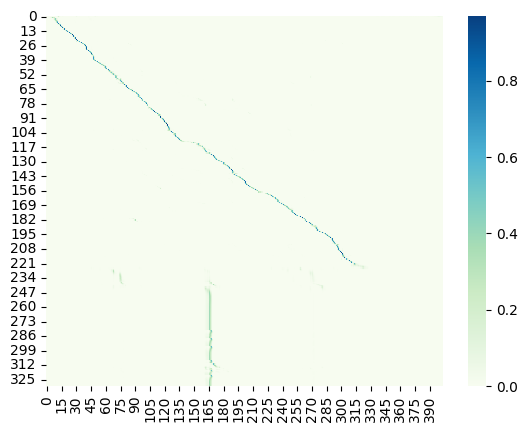

Saved epoch model

Epoch: 26/98


Val:   5%|▍         | 1/22 [00:02<00:57,  2.72s/it, dist=19.3516]

Ground Truth :  CLIMATE BAD EXAMPLE AND THE LUXURY OF POWER DEGRADED THEM IN ONE CENTURY INTO A RACE OF HELPLESS AND DEBAUCHED SLAVE HOLDERS DOOMED TO UTTER EXTERMINATION BEFORE THE SEMI GOTHIC ARMIES OF BELISARIUS AND WITH THEM VANISHED THE LAST CHANCE THAT THE GOTHIC RACES WOULD EXERCISE ON THE EASTERN WORLD THE SAME STERN YET WHOLESOME DISCIPLINE UNDER WHICH THE WESTERN HAD BEEN RESTORED TO LIFE
Prediction   :  CLIMBED BAD EXAMPLED AND THE LUBJERY OF POWER DEGREE THAT MAN ONE CENTURIED WERE RAISE OF HELPLESS AND HE BOUGHT SLAVE OLDERS DOONED TO AUTURNERS OF BELOSARIUS AND WITH THEM VANISHED THE LAST CHANCE THAT THE GOD THE GRACES WITH EXECISE ON THE EASTER WORLD THE SAME STURN YET HOLSON DISCIPLINE UNDER WHICH THE WESTERN HAD BEEN RESTORED TO MIFE


Val:   9%|▉         | 2/22 [00:05<01:00,  3.00s/it, dist=19.0859]

Ground Truth :  WHEN HIS PUBLIC SERVICES WERE FINISHED HE STARTED IN COMPANY WITH HIS WIFE SON JESSE AND A FEW FRIENDS
Prediction   :  WHEN HIS PUBLIC SERVICES WERE PINISHED HE STARTED IN COMPANY WITH HIS WIFE SOME JUSTY IN A FEW FRIENDS


Val:  14%|█▎        | 3/22 [00:08<00:54,  2.85s/it, dist=18.8333]

Ground Truth :  FROM THE SUN AS THE UNIVERSAL FATHER PROCEEDS THE QUICKENING PRINCIPLE IN NATURE AND IN THE PATIENT AND FRUITFUL WOMB OF OUR MOTHER THE EARTH ARE HIDDEN EMBRYOS OF PLANTS AND MEN
Prediction   :  ON THE SON AS THE UNIVERSAL FATHER PRECEDES THE QUICKING PRESS ALL IN NATURE IN IN THE PATIENT AND FREEFUL WOMAN OF HER MOTHER THE EARTH OR IT NEME REALS OF PLANTS AND MEN


Val:  18%|█▊        | 4/22 [00:11<00:50,  2.83s/it, dist=19.7559]

Ground Truth :  I TOLLED THE BELL AGAIN
Prediction   :  I TOLD THE BELL AGAIN


Val:  23%|██▎       | 5/22 [00:14<00:50,  2.98s/it, dist=20.0938]

Ground Truth :  HE SEEMS TO ME TO BE TRULY PENITENT FOR HIS OFFENCES A MISGUIDED BUT NOT A HYPOCRITICAL MAN IF MY KNOWLEDGE OF HUMAN NATURE GOES FOR ANYTHING I HOPE HE IS SAID NORTH
Prediction   :  HE SEEMS TO ME TO BE TRUE PENNETENT FOR AS EFFENCES A MISS GUIDED BUT NOT A HEPPECRITICAL MAN IF MY KNOWLEDGE OF HUMAN NATURE GOES FOR ANYTHING I HOPE IS SAID NORTH


Val:  27%|██▋       | 6/22 [00:17<00:46,  2.92s/it, dist=20.3698]

Ground Truth :  IT WAS INDEED DANCING ON A VOLCANO
Prediction   :  IT WAS INDEED DAMPSING ON A BOCKING O


Val:  32%|███▏      | 7/22 [00:20<00:42,  2.84s/it, dist=19.5938]

Ground Truth :  BEEN OVER THE GROUND STUDIED THE AFFAIR CAREFULLY
Prediction   :  THEN OVER THE GROUND STUDY TO THE AFFAIR CAREFULLY


Val:  36%|███▋      | 8/22 [00:23<00:40,  2.89s/it, dist=19.6699]

Ground Truth :  WHEN SHE HEARD OF MY ENGAGEMENT WITH MARY ANN SHE WROTE AND SUGGESTED THAT WE SHOULD SPEND OUR HONEYMOON IN HER COTTAGE OR PIGSTYE AND THAT I SHOULD PAY HER RENT FOR IT
Prediction   :  WHEN SHE HEARD OF MY ENGAGEMENT WITH MARRY AND SHE ROTE AND SUGGESTED THAT WE SHOULD SPEND OUR HONEY MOON IN HER CONNGEGE OR PINCE DIE AND THAT I SHOULD PAY HER RENT FOR IT


Val:  41%|████      | 9/22 [00:25<00:37,  2.87s/it, dist=20.1693]

Ground Truth :  HE ADDED SYDNEY'S ADDRESS IN A POSTSCRIPT AND DISPATCHED HIS LETTER THAT EVENING
Prediction   :  HE ADDED SUBMIES ADDRESS AND APPOSE CRIPT AND DISPATCHED HIS LETTER THAT EVENING


Val:  45%|████▌     | 10/22 [00:29<00:35,  2.94s/it, dist=20.0688]

Ground Truth :  NORTH KNEW WELL THAT HE WOULD NEVER DARE TO ATTEMPT ANY SUCH ACT OF VIOLENCE BUT THE INSULT STUNG HIM LIKE THE CUT OF A WHIP
Prediction   :  NORTH NEW WHILE THAT HE WOULD NEVER DARE TO ATTEMPT ANY SUCH ACTIVE VILENCE BUT THE INSULT STUNG HIM LIKE THE CUT OF A WIP


Val:  50%|█████     | 11/22 [00:32<00:32,  2.95s/it, dist=20.3274]

Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MAY BE ATTEMPT WITH SOME SEAL


Val:  55%|█████▍    | 12/22 [00:34<00:28,  2.84s/it, dist=20.1725]

Ground Truth :  WHEN I CAME UP HE TOUCHED MY SHOULDER AND LOOKED SEARCHINGLY DOWN INTO MY FACE FOR SEVERAL SECONDS
Prediction   :  WHEN I CAME UP HE TUCHED MY SHOULDER AND LOOKED SURCHING WE DOWN INTO MY FACE FOR SIMILA SECONDS


Val:  59%|█████▉    | 13/22 [00:37<00:26,  2.91s/it, dist=20.4940]

Ground Truth :  THIS AVENUE WAS STRAIGHT AND OF MODERATE LENGTH RUNNING BETWEEN A DOUBLE ROW OF VERY ANCIENT HORSE CHESTNUTS PLANTED ALTERNATELY WITH SYCAMORES WHICH ROSE TO SUCH HUGE HEIGHT AND NOURISHED SO LUXURIANTLY THAT THEIR BOUGHS COMPLETELY OVER ARCHED THE BROAD ROAD BENEATH
Prediction   :  THIS ABONY WAS STREET AND OF MODERATE LIKE RANG BETWEEN A DUCKLE ROW A VERY ACCENT HORSE TESTNUTS PLANTED ALTERATELY WAS SICK A WORSE WHICH ROSE TO SUCH HUGE HIGHS AND NURSE SO LUCURIANTLY THAT THEIR BAST HIMPLY LEAVE HER ARCHED THE BROAD ROAD ANY


Val:  64%|██████▎   | 14/22 [00:40<00:22,  2.86s/it, dist=20.2595]

Ground Truth :  HE WATCHED HIM GESTICULATING AND MURMURING IN THE KITCHEN
Prediction   :  HE WASHED HIM TO STICK LATE HIM URMURING IN THE KITCHEN


Val:  68%|██████▊   | 15/22 [00:43<00:19,  2.81s/it, dist=20.0328]

Ground Truth :  ASPARAGUS SALAD COOK THE ASPARAGUS IN SALTED WATER DRAIN AND CHILL
Prediction   :  A SPARE IT DISALID QUOKE THE ESPERIGUS INSULTED WATER DRAIN AND CHILL


Val:  73%|███████▎  | 16/22 [00:45<00:16,  2.82s/it, dist=19.8203]

Ground Truth :  YOU WILL LET ME DO IT AND IN RETURN I WILL MARRY YOU WHENEVER YOU ASK ME ANSWERED CHRISTIE SEALING THE PROMISE WITH A KISS THAT SILENCED HIM
Prediction   :  YOU WILL LET ME DO IT AND WHEN RETURNED I WILL MARRY YOU WHEN EVERY USK ME ANSWERED CRISTY SEEING THE PROMISE WITH THE KISSED THAT SILE INSTAN


Val:  77%|███████▋  | 17/22 [00:48<00:13,  2.78s/it, dist=19.7077]

Ground Truth :  HE HONOURS WHATEVER HE RECOGNIZES IN HIMSELF SUCH MORALITY EQUALS SELF GLORIFICATION
Prediction   :  HE HONORS WHATEVER HE RECOGNIZES IN HIMSELF SUCH MORALITY EQUALS SELF GLORIFICATION


Val:  82%|████████▏ | 18/22 [00:51<00:11,  2.87s/it, dist=19.7721]

Ground Truth :  THE FAT THEY ARE FRIED IN SHOULD BE CLEAR AND THE CRUMBS SHOULD NOT HAVE THE SLIGHTEST APPEARANCE OR TASTE OF HAVING BEEN IN THE LEAST DEGREE BURNT
Prediction   :  THE FAD THERE FRIEND AND SHE BECLEARE AND THE CRUMB SHOULD NOT HAVE THE SLIGHTEST APPEARANCE OR TASTE OF HAVING BEEN IN THE LEAST AGREE FIRGS


Val:  86%|████████▋ | 19/22 [00:54<00:08,  2.87s/it, dist=19.7023]

Ground Truth :  AS THE LIFE BLOOD OF THE LANDSCAPES THE BEST OF THE WILDERNESS COMES TO THEIR BANKS AND NOT ONE DULL PASSAGE IS FOUND IN ALL THEIR EVENTFUL HISTORIES
Prediction   :  AS THE LIFE BLOOD OF THE LANDSCAPES THE BEST OF THE WILDERNESS COME TO THEIR BANKS AND NOT ONE DOLL PASSAGE IS FOUND IN ALL THEIR AVENTFUL HISTORIES


Val:  91%|█████████ | 20/22 [00:57<00:05,  2.88s/it, dist=19.6207]

Ground Truth :  AND WHOEVER THOU ART WHAT IS IT THAT NOW PLEASES THEE
Prediction   :  AND WHO OVER THAT WITH IS IT THAT NOW PLEASES THEE


Val:  95%|█████████▌| 21/22 [01:00<00:02,  2.97s/it, dist=19.6336]

Ground Truth :  YET THE MOST CHARITABLE CRITICISM MUST REFUSE THESE SECTARIES ANY KNOWLEDGE OF THE PURE AND PROPER DIVINITY OF CHRIST
Prediction   :  YET THE MOST CHARITABLE CURTISIS AND MUST REFUSE THESE SECURIES ANY KNOWLEDGE OF THE PURE AND PROPER DIVINITY OF CHRIST


Ground Truth :  THEN THEY BEGAN TO RUN AND RUSHING INTO THE HOUSE THEY FELL UPON THEIR FATHER'S NECK
Prediction   :  THEN THEY BEGAN TO RUN AND WHAT SHE INTO THE HOUSE THEY FELL UPON THEIR FATHER'S NECK
Train loss: 0.9204481193302992 Train Perplexity: 2.527982363251827 lr:  0.0001
Validation dist:  19.359303977272727


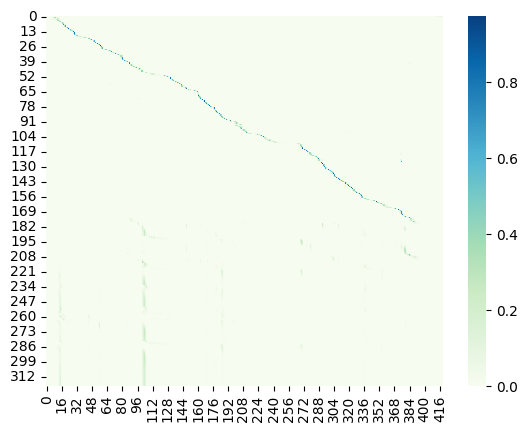

Saved epoch model

Epoch: 27/98


Val:   5%|▍         | 1/22 [00:02<00:55,  2.66s/it, dist=13.9297]

Ground Truth :  ANY ANSWER I GUESS NOT
Prediction   :  AND HE ANSWERED I GUESS NOT


Val:   9%|▉         | 2/22 [00:05<00:56,  2.82s/it, dist=13.7305]

Ground Truth :  NECESSITY HAD BECOME HIS GRIM MASTER AND THE FOLLOWING WEEK HE WAS GOING TO WORK
Prediction   :  NECESSITY HAD BECOME HIS GROOM MASTER AND THE FALLEN WEEK HE WAS DOING TOWARK


Val:  14%|█▎        | 3/22 [00:08<00:53,  2.83s/it, dist=14.2214]

Ground Truth :  THE VANITY OF CELESTINE WAS FLATTERED BY THE APPEAL AND THE PARTIAL VERSION OF A MONK DECIDED THE FAITH OF THE POPE WHO WITH HIS LATIN CLERGY WAS IGNORANT OF THE LANGUAGE THE ARTS AND THE THEOLOGY OF THE GREEKS
Prediction   :  THE VANITY OF KALACE IN WAS FLATTERED BY THE APPEAL AND THE PARSONAL VERSON OF AMONG TO SIDE OF THE FATE OF THE POPE WHO WITH HIS LAND AND CLERTY WAS INNER INTO THE LANGUAGE THE ARTS AND THE THEOLOGY OF THE GREEKS


Val:  18%|█▊        | 4/22 [00:11<00:52,  2.89s/it, dist=15.1348]

Ground Truth :  HAVE YOU MANY VISITORS CAPTAIN BURGESS VERY FEW
Prediction   :  HAVE YOU MANY VISITOR SCAPPED AND BURGESS VERY FEW


Val:  23%|██▎       | 5/22 [00:14<00:50,  2.97s/it, dist=16.3219]

Ground Truth :  GO QUIETLY ALONE NO HARM WILL BEFALL YOU
Prediction   :  GO QUIETLY ALONE GO HARMWHILE BEFOLL YOU


Val:  27%|██▋       | 6/22 [00:17<00:47,  2.96s/it, dist=16.4102]

Ground Truth :  SHE LISTENED INTENTLY BUT SHE HEARD NOTHING BUT THE CREAKING OF HIS CHAIR
Prediction   :  SHE LISTENED INTENDLY BUT SHE HEARD NOTHING BUT THE CREATING OF HIS CHAIR


Val:  32%|███▏      | 7/22 [00:20<00:45,  3.02s/it, dist=16.4230]

Ground Truth :  I'VE BEEN UP IN CANADA WITH MY BRIDGE AND I ARRANGED NOT TO COME TO NEW YORK UNTIL AFTER YOU HAD GONE
Prediction   :  I BEEN UP AND CANADA WITH MY BRIDGE AND I RANGED NOT TO COME TO NEW YORK INTO AFTER YOU HAD GONE


Val:  36%|███▋      | 8/22 [00:23<00:42,  3.00s/it, dist=16.1709]

Ground Truth :  IN THIS TYPE OF PRAYER THERE WAS NO BESEECHING OF FAVOR OR HELP
Prediction   :  IN THE STATE OF PRAYER THERE WAS NO DESEECHING AND FAVOUR OR HELP


Val:  41%|████      | 9/22 [00:26<00:39,  3.03s/it, dist=16.0182]

Ground Truth :  HIS AMBITION WAS SOME DAY TO BUILD A HOUSE ON THEM
Prediction   :  HIS AMBITION WAS SOME DAY TO BELL THE HOUSE ON THEM


Val:  45%|████▌     | 10/22 [00:29<00:35,  2.96s/it, dist=15.7812]

Ground Truth :  THE GREAT GREEN FIELD SURROUNDED ON ALL SIDES BY TALL TREES MADE THE PLACE AN IDEAL ONE FOR THEIR PURPOSE
Prediction   :  THE GREAT GREEN FILLED SURRENDED ON ALL SIGHT LY TOLD TREES MADE THE PLACE IN IDEAL ONE FOR THEIR PURPOSE


Val:  50%|█████     | 11/22 [00:32<00:32,  2.98s/it, dist=15.7841]

Ground Truth :  NATURE A DIFFERENCE OF FIFTY YEARS HAD SET A PROFOUND GULF BETWEEN JEAN VALJEAN AND COSETTE DESTINY FILLED IN THIS GULF
Prediction   :  NATURE I DIFFERENCE OF FIFTY YEARS HAD SET A PROFOUND GOLTH BETWEEN SHUNFALCHON INTO HIS ET GEST TO THE FILLED IN FISCHOLF


Val:  55%|█████▍    | 12/22 [00:35<00:30,  3.00s/it, dist=16.0456]

Ground Truth :  INDEED WE OF THE RANK AND FILE HAD LITTLE CONFIDENCE IN GRANT IN THOSE DAYS
Prediction   :  INDEED WE OF THE RANK AND FILL HAD LITTLE CONFIDENCE IN GRANT IN THOSE DAYS


Val:  59%|█████▉    | 13/22 [00:38<00:26,  2.98s/it, dist=16.3498]

Ground Truth :  DO YOU KNOW ALEXANDER MAINHALL LOOKED WITH PERPLEXITY UP INTO THE TOP OF THE HANSOM AND RUBBED HIS PINK CHEEK WITH HIS GLOVED FINGER DO YOU KNOW I SOMETIMES THINK OF TAKING TO CRITICISM SERIOUSLY MYSELF
Prediction   :  DO NO ELEXANDER MAN HALL LOOKED WITH PERPLEXITY UP INTO THE TOP OF THE HANDSOME AND RUBBED HIS PINK TO CHEEK WITH HIS GLOME TO FINGER DO YOU KNOW I SOMETIMES THINK OF TAKING TO CRITICISM SERIOUSLY MYSELF


Val:  64%|██████▎   | 14/22 [00:41<00:23,  2.95s/it, dist=16.3850]

Ground Truth :  THE SECOND BEGINS HERE AN ANGEL THE THIRD HERE DEAR SONG I KNOW
Prediction   :  THE SECOND BEGINS HERE AND ANCIEL THE THIRD HERE DO SON I KNOW


Val:  68%|██████▊   | 15/22 [00:44<00:20,  2.97s/it, dist=16.4854]

Ground Truth :  MODE PUT THE WHOLE OF THE INGREDIENTS INTO A BOTTLE AND LET IT REMAIN FOR A FORTNIGHT IN A WARM PLACE OCCASIONALLY SHAKING UP THE CONTENTS
Prediction   :  MODE BUT THE HOLE OF THE INGREDIENCE INTO A BUTTLE HENETTED REMAIN FOR A FORTNIGHT IN A WARM PLACE OCCASIONALLY SHAKING UP THE CONTENTS


Val:  73%|███████▎  | 16/22 [00:47<00:17,  3.00s/it, dist=16.3945]

Ground Truth :  WHOM IS HE GOING TO FLOG NOW
Prediction   :  WHOM IS HE ONLY TO FLOAT NOW


Val:  77%|███████▋  | 17/22 [00:50<00:14,  2.98s/it, dist=16.2266]

Ground Truth :  HE SUFFERED ALL THE PANGS OF A MOTHER AND HE KNEW NOT WHAT IT MEANT FOR THAT GREAT AND SINGULAR MOVEMENT OF A HEART WHICH BEGINS TO LOVE IS A VERY OBSCURE AND A VERY SWEET THING
Prediction   :  HE SUFFERED ALL THE KINDS OF A MOTHER AND HE KNEW NOT WHAT IT MEANT FOR THAT GREAT AND SINGULAR MOVEMENT OF A HEART WHICH BEGINS TO LOVE IS A VERY OF SURE AND A VERY SWEET THING


Val:  82%|████████▏ | 18/22 [00:53<00:11,  2.99s/it, dist=16.0182]

Ground Truth :  HOW CAN WE FEED OUR CHILDREN WHEN WE HAVE NO MORE THAN WE CAN EAT OURSELVES
Prediction   :  HOW COMMY FEET OUR CHILDREN WHEN WE HAVE NO MORE THAN WE CAN EAT OURSELVES


Val:  86%|████████▋ | 19/22 [00:56<00:08,  2.92s/it, dist=15.8890]

Ground Truth :  MEBBY YOU THINK HE'S HAVING SOME SORT OF A PICNIC DOWN THERE EH GLARED LIGE
Prediction   :  MAYBE USINK HE SAID HE SOME SERVING A PICKET DOWN THE ARE AND LANGER BLIED


Val:  91%|█████████ | 20/22 [00:59<00:05,  2.93s/it, dist=15.7406]

Ground Truth :  HURSTWOOD ALMOST EXCLAIMED OUT LOUD AT THE INSISTENCY OF THIS THING
Prediction   :  HERSEWON ALMOST EXCLAIMED OUTLOWED AT THE INSISTENCY OF THIS THING


Val:  95%|█████████▌| 21/22 [01:01<00:02,  2.83s/it, dist=15.6276]

Ground Truth :  NEVER USE NEW BREAD FOR MAKING ANY KIND OF TOAST AS IT EATS HEAVY AND BESIDES IS VERY EXTRAVAGANT
Prediction   :  NEVER USE NO BREAD FOR MAKING ANY KIND OF TOAST AS IT EACH HEAVY IN BESIDES DISVERY EXTRAVACANT


Ground Truth :  ONE DAY WHEN I RODE OVER TO THE SHIMERDAS I FOUND ANTONIA STARTING OFF ON FOOT FOR RUSSIAN PETER'S HOUSE TO BORROW A SPADE AMBROSCH NEEDED
Prediction   :  ONE DAY WHEN I RODE OVER TO THE SHIMARITES I FOUND INTO ME A STARTING OFF ON FOOT FOR RUSHING PETER'S HOUSE TO BARLESS SPAID EMBROSH MEATING
Train loss: 0.9037536259723886 Train Perplexity: 2.4831580463546272 lr:  0.0001
Validation dist:  15.677864583333333


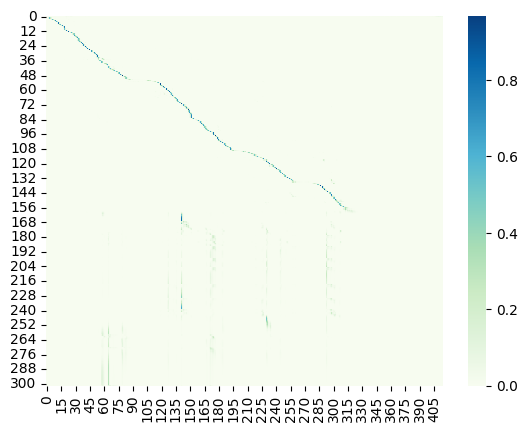

Saved epoch model
Saved best model

Epoch: 28/98


Val:   5%|▍         | 1/22 [00:02<00:58,  2.76s/it, dist=17.2031]

Ground Truth :  A YELLOW VARIETY CALLED GOLDEN MILLET IS SOLD IN THE GROCERS SHOPS FOR MAKING PUDDINGS AND IS VERY DELICATE AND WHOLESOME
Prediction   :  A YELLOW VARIETY CALLED A GOLDEN MILLET IS SO IN THE GROSSER SHOPS FOR MAKING PUTTINGS AND IS VERY DELICATE AND HOLSON


Val:   9%|▉         | 2/22 [00:05<00:55,  2.78s/it, dist=16.4141]

Ground Truth :  HE PAUSED AND PUT HIS HAND TO HIS FEVERED HEAD
Prediction   :  HE POLISTED AND PUT HIS HAND IT WAS FEET FOR HEAD


Val:  14%|█▎        | 3/22 [00:08<00:54,  2.87s/it, dist=15.9245]

Ground Truth :  THERE MUST BE A SORT OF REPUGNANCE IN ME TO BELIEVE ANYTHING DEFINITE ABOUT MYSELF IS THERE PERHAPS SOME ENIGMA THEREIN
Prediction   :  THE MUST BE A SORT OF REPUTTANCE IN ME TO BELIEVE ANY HIM DEATHING AT ABOUT MYSELF IS THERE PERHAPS SOME IN THE GMIT OF THEIR RIM


Val:  18%|█▊        | 4/22 [00:11<00:50,  2.82s/it, dist=15.5605]

Ground Truth :  NO ONE WHO IS HIMSELF HONEST WILL DOUBT MY BEING SO
Prediction   :  NO ONE WHO IS HIMSELF ON AS WILL DOUBT MY BEING SO


Val:  23%|██▎       | 5/22 [00:14<00:50,  2.98s/it, dist=16.0906]

Ground Truth :  SHE MADE MISSUS SHIMERDA UNDERSTAND THE FRIENDLY INTENTION OF OUR VISIT AND THE BOHEMIAN WOMAN HANDLED THE LOAVES OF BREAD AND EVEN SMELLED THEM AND EXAMINED THE PIES WITH LIVELY CURIOSITY EXCLAIMING MUCH GOOD MUCH THANK
Prediction   :  SHE MADE MISSUS REMARED UNDERSTAND THE FRIENDLY INTENTION OF OUR VISIT IN THE BOHUMIAN WOMAN HANDLED THE LOWS OF BREAD AND EVEN SMELLED THEM AND EXAMINED THE PIES WITH LIVELY CURIOSITY EXCLAIMING MUCH GOOD MUCH THAKE


Val:  27%|██▋       | 6/22 [00:17<00:48,  3.01s/it, dist=16.4258]

Ground Truth :  THAT LAST FELLOW YOU HAD OUGHT TO HAVE BEEN TIED UP HIMSELF
Prediction   :  AT LAST THOUGH A YOU HAD OUGHT TO HAVE BEEN TIGHT UP HIMSELF


Val:  32%|███▏      | 7/22 [00:20<00:44,  2.98s/it, dist=16.0212]

Ground Truth :  IT IS WELL KNOWN THAT THE AMERICAN INDIAN HAD SOMEHOW DEVELOPED OCCULT POWER AND ALTHOUGH IN THE LATTER DAYS THERE HAVE BEEN MANY IMPOSTORS AND ALLOWING FOR THE VANITY AND WEAKNESS OF HUMAN NATURE IT IS FAIR TO ASSUME THAT THERE MUST HAVE BEEN SOME EVEN IN THE OLD DAYS YET THERE ARE WELL ATTESTED INSTANCES OF REMARKABLE PROPHECIES AND OTHER MYSTIC PRACTICE
Prediction   :  IT IS WELL KNOWN THAT THE AMERICAN INDIAN HAD SOME HOW DEVELOPED OF COLD POWER AND ALLOWING THE LATTER DAYS THERE HAD BEEN MANY IMPOSTURES AND ALONE FOR THE VANINTY IN WEAKNESS OF HUMAN NATURE IT IS FAIRED TO A SOON THAT THERE MUST HAVE BEEN SOME EVEN IN THE OLD DAYS YET THERE ARE WELL ATTESTED INSTANCES OF REMARKABLE PROFICES AND OTHER MISTIC PRACTICE


Val:  36%|███▋      | 8/22 [00:23<00:42,  3.03s/it, dist=15.8184]

Ground Truth :  THE SHRIEKS THAT FOLLOWED MADE EVERYBODY SOBER
Prediction   :  THE SHREEKS THAT FOLLOWED ME EVERYBODY SOBER


Val:  41%|████      | 9/22 [00:26<00:40,  3.09s/it, dist=15.7170]

Ground Truth :  AND HE WALKED IMMEDIATELY OUT OF THE APARTMENT BY ANOTHER DOOR
Prediction   :  AND HE WALKED IMMEDIATELY OUT OF THE APARTMENT BY ANOTHER DOOR


Val:  45%|████▌     | 10/22 [00:29<00:36,  3.05s/it, dist=16.1125]

Ground Truth :  THE PONY DID MOST OF IT ADMITTED THE LAD I JUST GAVE HIM HIS HEAD AND THAT'S ALL THERE WAS TO IT
Prediction   :  THE PONY DID MOST OF IT IMMITTED THE LAD I JUST GAVE OF HIS HEAD AND THAT'S ALL THERE WAS TO IT


Val:  50%|█████     | 11/22 [00:32<00:33,  3.01s/it, dist=16.2749]

Ground Truth :  KNOWING THAT GOD SETS NO VALUE UPON MATERIAL THINGS HE TOOK WITH HIM NO OFFERINGS OR SACRIFICES OTHER THAN SYMBOLIC OBJECTS SUCH AS PAINTS AND TOBACCO
Prediction   :  KNOWING THEY GOD SITS NO VALUE UPON THE CHAIRL THINGS HE TOOK WITH A NORAFFRIMS OF SACRIFICE AS OTHER THAN SING ALL OF OBJECTS SUCH AS PAINS INTO MARKEL


Val:  55%|█████▍    | 12/22 [00:35<00:29,  2.92s/it, dist=16.5957]

Ground Truth :  LET ME THINK HE SAID OH HOW GLAD I AM THAT YOU HAPPENED TO COME THIS WAY
Prediction   :  BUT WE THINK HE SAID I HOW GRAND I AM THEY HAPPENED A COME HIS WAY


Val:  59%|█████▉    | 13/22 [00:38<00:26,  2.94s/it, dist=16.2873]

Ground Truth :  BECAUSE HE TALKED SO LITTLE HIS WORDS HAD A PECULIAR FORCE THEY WERE NOT WORN DULL FROM CONSTANT USE
Prediction   :  BECAUSE HE TALKED SO LITTLE HIS WORDS HAD A PECULIAR FORCE THEY WERE NOT MORE IN DULL FROM CONSTANT USE


Val:  64%|██████▎   | 14/22 [00:41<00:23,  2.98s/it, dist=16.1183]

Ground Truth :  THE BOYS BLESS THEIR BRAVE HEARTS HAVE DONE NOBLY BUT OLDER MEN ARE NEEDED NOW WE CANNOT SACRIFICE ALL THE GALLANT LADS AND WE WHO HAVE MORE TO LOSE THAN THEY MUST TAKE OUR TURN AND TRY TO DO AS WELL
Prediction   :  THE BOYS BLESS THEIR BRAVE HEARD SO DUNNOBLY BUT OLDER MINNER NEEDED NO WE CANNOT SACRIFICE ALL THE GALLANT LODS AND WE WHO HAVE MORE TO LOSE AND THEY MUST TAKE OUR TURN AND TRY TO DO HIS WELL


Val:  68%|██████▊   | 15/22 [00:44<00:20,  2.98s/it, dist=16.0958]

Ground Truth :  HE DID MANAGE TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRIE BUT WHEN HE GOT IN OGDEN PLACE HE THOUGHT HE SAW A MAN WATCHING HIM AND WENT AWAY
Prediction   :  HE DID MINISHED THE BRING HIMSELF INTO THE MIDDLE TO GO AT TO CARRY BUT WHEN HE BOUGHT IN ON THEM PLACE HE BOUGHT HE SAW MAN MOCHING HIM AND MED WAY


Val:  73%|███████▎  | 16/22 [00:47<00:17,  2.88s/it, dist=15.9521]

Ground Truth :  AND THEN HE TALKED OF HER MOTHER AND HE MADE HER PRAY
Prediction   :  AND THEN HE TALKED IF HER MOTHER AND HE MADES HER PRAY


Val:  77%|███████▋  | 17/22 [00:49<00:14,  2.80s/it, dist=15.7063]

Ground Truth :  THE SHARP SMELL OF SPIRITS WENT THROUGH THE ROOM
Prediction   :  THE SHARP SMELL OF SPIRITS WENT THROUGH THE ROOM


Val:  82%|████████▏ | 18/22 [00:52<00:11,  2.76s/it, dist=15.8155]

Ground Truth :  YOU ASK ME TO STAY AWAY FROM YOU BECAUSE YOU WANT ME
Prediction   :  YOU ASK WE TO STAY AWAY FROM YOU BECAUSE YOU WANT ME


Val:  86%|████████▋ | 19/22 [00:55<00:08,  2.88s/it, dist=15.8166]

Ground Truth :  A FLOODLIGHT WAS ON IN THE ROOM INSIDE AND LATTIMER WAS GOING AROUND LOOKING AT THINGS WHILE A SPACE FORCE OFFICER STOOD BY THE DOOR
Prediction   :  A FOOD LIGHT WAS ON IN THE ROOM IN SIDE AND LAD IMMER WAS GOING AROUND LOOKING AT THINGS WHILE THE SPACE FOR SOFT AS HER STOOD BY THE DOOR


Val:  91%|█████████ | 20/22 [00:58<00:05,  2.81s/it, dist=15.6887]

Ground Truth :  HE WAS STONE DEAD BUT I DROPPED THAT FOOT QUICK
Prediction   :  HE WAS STONE DEAD BUT I DROPPED AT FOOT QUICK


Val:  95%|█████████▌| 21/22 [01:01<00:02,  2.82s/it, dist=15.6812]

Ground Truth :  THE ROPE HOWEVER WAS STRONGER THAN THE MULE'S NO AND HE WAS FINALLY PREVAILED UPON BY THE STRENGTH OF THE ROPE TO CROSS THE CREEK
Prediction   :  THE ROLL POWEVER WAS STRONGER THAN MULES NO AND HE WAS FINALLY PREVAILED UPON BY THE STRANK OF THE ROAD TO CROSS THE CREEK


Ground Truth :  FOR SOME REASON HE FELT AS IF SOMETHING MIGHT COME THAT WAY AND WAS RELIEVED WHEN ALL THE ENVELOPES HAD BEEN SCANNED AND NOTHING SUSPICIOUS NOTICED
Prediction   :  FOR SOME REASON HE FELT AS IF SOMETHING MIGHT COME THAT WAY AND WAS RELIEVED WHEN ALL THE HUMBLE OF SHOULD BEEN SCAND AND NOTHING SUSPICIOUS NOTICED
Train loss: 0.9015932165988357 Train Perplexity: 2.4784633760495036 lr:  0.0001
Validation dist:  15.868394886363637


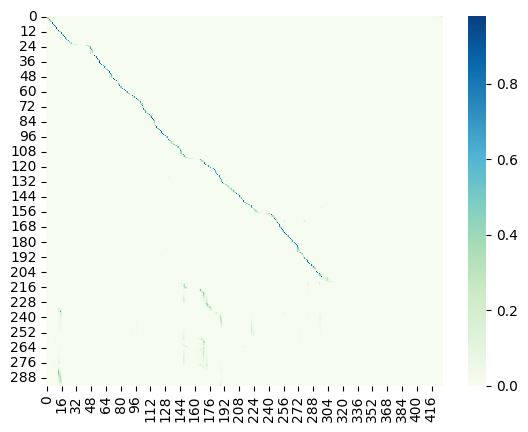

Saved epoch model

Epoch: 29/98


Train:  84%|████████▍ | 187/223 [25:43<04:51,  8.11s/it, loss=0.8906, lr=0.0001, perplexity=2.4537, tf_rate=0.90]

In [ ]:
torch.autograd.set_detect_anomaly(True)
best_lev_dist = float("inf")
last_epoch = ckpt['epoch']
for epoch in range(last_epoch, meta_config.epochs):
    
    print("\nEpoch: {}/{}".format(epoch+1, meta_config.epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])


    # Call train and validate, get attention weights from training
    loss, perplexity, attention_plot = train(model, train_loader, criterion, optimizer, teacher_forcing_rate = meta_config.teacher_forcing_ratio)
    valid_dist = validate(model, dev_loader)
    # Print your metrics
    print("Train loss: " + str(loss) + " Train Perplexity: " + str(perplexity) + " lr: ", str(curr_lr))
    print("Validation dist: ", valid_dist)




    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy())

    # Log metrics to Wandb
    wandb.log({
            'train_loss': loss,  
            'valid_dist': valid_dist, 
            'lr'        : curr_lr
        })
    
    save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)
    wandb.run.save(epoch_model_path)
    print("Saved epoch model")

    if epoch >=15:
        scheduler.step(valid_dist)
    meta_config.teacher_forcing_ratio = tf_scheduler.reduce_tf(epoch)
    


    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        wandb.run.save(best_model_path)
        print("Saved best model")
        # Save your model checkpoint here

run.finish()

# Testing

In [ ]:
print(model.parameters)

In [ ]:
test_results = []
def calc_distance_preds(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx, 0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above and uncomment below for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

In [ ]:

def test(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, lx) in enumerate(dataloader):
        '''if x.shape[0] != config['batch_size']:
            continue'''

        x, lx = x.to(device) lx

        with torch.no_grad():
            raw_predictions, attentions = model(x, lx, y = None, teacher_forcing_ratio = 0)

        # Greedy Decoding
        # raw_predictions ----> (B, T, vocab_size)
        # y ----> (B, T)
        greedy_predictions   = torch.argmax(raw_predictions, dim = -1) # TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        #running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = True) # You can use print_example = True for one specific index i in your batches if you want

        batch_size, seq_len = greedy_predictions.shape

        for batch_idx in range(batch_size): 

            #y_sliced    = indices_to_chars(y[batch_idx, 0:ly[batch_idx]], vocab)
            pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

In [ ]:
def convert_to_list(predictions, vocab= VOCAB, print_example= False):

    batch_size, seq_len = predictions.shape
    pred_list = []

    for batch_idx in range(batch_size): 

        #y_sliced    = indices_to_chars(y[batch_idx, 0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        #y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        pred_list.append(pred_string)
        
        #dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above and uncomment below for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

        if print_example: 
            # Print y_sliced and pred_sliced if you are using the toy dataset
            #print("Ground Truth : ", y_string)
            print("Prediction   : ", pred_string)
        
    #dist/=batch_size
    print(len(pred_list))
    return pred_list

In [ ]:
def test(model, dataloader):
    test_predictions = []
    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Test")

    running_lev_dist = 0.0

    for i, (x, lx) in enumerate(dataloader):
        '''if x.shape[0] != config['batch_size']:
            continue'''

        x, lx = x.to(device), lx

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None, teacher_forcing_ratio = 0)

        # Greedy Decoding
        # raw_predictions ----> (B, T, vocab_size)
        # y ----> (B, T)
        greedy_predictions   = torch.argmax(raw_predictions, dim = -1) # TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        test_predictions.extend(convert_to_list(greedy_predictions, VOCAB, print_example = False)) # You can use print_example = True for one specific index i in your batches if you want

        #batch_bar.set_postfix(
        #    dist="{:.04f}".format(running_lev_dist/(i+1)))
        #batch_bar.update()

        del x, lx
        torch.cuda.empty_cache()

    #batch_bar.close()
    #running_lev_dist /= len(dataloader)

    return test_predictions

In [ ]:
test_loader = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size = config['batch_size'])


In [ ]:
ckpt = torch.load('best_model-schedule-run-6.pth')
model.load_state_dict(ckpt['model_state_dict'])
test_predictions = test(model, test_loader)

In [ ]:
#test_results_new = ["".join(arr) for arr in test_predictions]
print(len(test_predictions))

In [ ]:
data_dir = 'data/test-clean/random_submission.csv'
df = pd.read_csv(data_dir)
df.label = test_predictions
df.to_csv('submission.csv', index = False)


In [ ]:
import csv
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # write the header row
    writer.writerow(['index', 'label'])

    # write each item in the list with its index
    for i, item in enumerate(test_predictions):
        writer.writerow([i, item])

In [ ]:
!kaggle competitions submit -c attention-based-speech-recognition-slack -f submission.csv -m "Message"